

Anomaly detection is not a new concept or technique, it has been around for a number of years and is a common application of Machine Learning. **The real world examples of its use cases include** (<font color='brown'>but not limited to</font>) **detecting fraud transactions, fraudulent insurance claims, cyber attacks to detecting abnormal equipment behaviors**.

In this Report , I will focus on the application of anomaly detection in the Manufacturing industry which I believe is an industry that lagged far behind in the area of effectively taking advantage of Machine Learning techniques compared to other industries.

### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'>[**The Problem Description**](#sect1)</font>
* <font size='3ptx'>[**The Data**](#sect2)</font>
    * [**Data Preprocess**](#sect2_1)
    * [**Exploratory Data Analysis (EDA)**](#sect2_2)
    * [**Stationarity and Autocorrelation**](#sect2_3)
    * [**Dimensionality Reduction**](#sect2_4)
* <font size='3ptx'>[**The Models**](#sect3)</font>
    * [**Benchmark model: Interquartile Range (IQR)**](#sect3_1)
    * [**K-Means clustering**](#sect3_2)
    * [**Isolation Forest**](#sect3_3)
* <font size='3ptx'>[**Model Evaluation**](#sect4)</font>
    

<a id='sect1'></a>
## <font color='darkblue'>The Problem Description</font>
Manufacturing industry is considered a heavy industry in which they tend to utilize various types of heavy machinery such as giant motors, pumps, pipes, furnaces, conveyor belts, haul trucks, dozers, graders, and electric shovels etc. These are often considered as the most critical assets for their operations. Therefore, **the integrity and reliability of these equipment is often the core focus of their Asset Management programs.**

The prime reason why they care so much about these assets is that the **failure of these equipment often results in production loss that could consequently lead to loss of hundreds of thousands of dollars if not millions depending on the size and scale of the operations**. So this is a pretty serious deal for a Maintenance Manager of a manufacturing plant to run a robust Asset Management framework with highly skilled Reliability Engineers to ensure the reliability and availability of these critical assets.

**Therefore, the ability to detect anomalies in advance and be able to mitigate risks is a very valuable capability which further allows preventing an unplanned downtime, unnecessary maintenance** (<font color='brown'>condition based vs mandatory maintenance</font>) **and will also enable more effective way of managing critical components for these assets**. The production loss from unplanned downtime, the cost of unnecessary maintenance and having excess or shortage of critical components translate into serious magnitudes in terms of dollar amount.

<font size='3ptx'>**In this post, I will implement different anomaly detection techniques in Python with Scikit-learn**</font> (<font color='brown'>aka sklearn</font>) <font size='3ptx'>**and our goal is going to be to search for anomalies in the time series sensor readings from a pump with unsupervised learning algorithms**</font>. 

Let’s get started!

<a id='sect2'></a>
## <font color='darkblue'>The Data</font>
It is very hard to find a public data from a manufacturing industry for this particular use case but I was able to find one that is not perfect. **The data set contains sensor readings from 53 sensors installed on a pump to measure various behaviors of the pump**. This data set can be found [here](https://www.kaggle.com/nphantawee/pump-sensor-data).

First, I will download the data using the following code and Kaggle API

In [ ]:
#!pip install statsmodels

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix

In [2]:
def load_data():
    df = pd.read_csv(r'S:\CODING NOTES\PYTHON3.0\CSV files\sensor.csv')
    return df

df = load_data()
df.shape

(220320, 55)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

<a id='sect2_1'></a>
### <font color='darkgreen'>Data Preprocess</font>
We can already see that the **data requires some cleaning, there are missing values, an empty column and a timestamp with an incorrect data type.** So I will apply the following steps to tidy up the data set:
* Remove redundant columns
* Remove duplicates
* Handle missing values
* Convert data types to the correct data type

In [4]:
# Drop duplicate row
df_tidy = df.drop_duplicates()

# Entire "sensor_15" column is NaN therefore remove it from data
del df_tidy['sensor_15']

# Let's convert the data type of timestamp column to datatime format
import warnings
warnings.filterwarnings("ignore")
df_tidy['date'] = pd.to_datetime(df_tidy['timestamp'])
del df_tidy['timestamp']

In [5]:
df_tidy.shape

(220320, 54)

**Next, let’s handle the missing values and for that let’s first see the columns that have missing values and see what percentage of the data is missing**. To do that, I’ll write a function that calculates the percentage of missing values:

In [6]:
t = df_tidy.isnull().sum().sort_values(ascending=False) / len(df_tidy)
t[:10]  # top10 columns with most null count

sensor_50    0.349569
sensor_51    0.069821
sensor_00    0.046333
sensor_07    0.024741
sensor_08    0.023180
sensor_06    0.021777
sensor_09    0.020856
sensor_01    0.001675
sensor_30    0.001185
sensor_29    0.000327
dtype: float64

In [7]:
# Function that calculates the percentage of missing values
def calc_percent_NAs(df):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

# Let's use above function to look at top ten columns with NaNs
calc_percent_NAs(df_tidy).head(10)

percent
sensor_50  0.349569
sensor_51  0.069821
sensor_00  0.046333
sensor_07  0.024741
sensor_08  0.023180
sensor_06  0.021777
sensor_09  0.020856
sensor_01  0.001675
sensor_30  0.001185
sensor_29  0.000327

After some analysis, I decided to impute some of the missing values with their mean ([API:fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html?highlight=fillna#pandas.DataFrame.fillna)) and drop the rest ([API:drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html)). After data wrangling process, my final tidy data looks as follows and is ready for the next step which is <font color='darkblue'>**Exploratory Data Analysis**</font>. 

In [8]:
df_tidy.columns

Index(['Unnamed: 0', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03',
       'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08',
       'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13',
       'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19',
       'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24',
       'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29',
       'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34',
       'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39',
       'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44',
       'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49',
       'sensor_50', 'sensor_51', 'machine_status', 'date'],
      dtype='object')

In [9]:
# Drop column 'sensor_50', 'sensor_51'
df_tidy = df_tidy.drop(['sensor_50', 'sensor_51', 'Unnamed: 0'], axis=1)
df_tidy.shape

(220320, 51)

In [10]:
df_tidy_mean_series = df_tidy.iloc[:, :-2].mean()



In [11]:
df_tidy_mean_series[:5]

sensor_00      2.372221
sensor_01     47.591611
sensor_02     50.867392
sensor_03     43.752481
sensor_04    590.673936
dtype: float64

In [12]:
# Fill missing value with mean value for other columns
df_tidy = df_tidy.fillna(df_tidy_mean_series)

The tidy data set has 52 sensors, `machine status` column that contains three classes (<font color='brown'>NORMAL, BROKEN, RECOVERING</font>) which represent normal operating, broken and recovering conditions of the pump respectively and then the datetime column which represents the timestamp.

In [13]:
df_tidy.head()

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  sensor_05  \
0   2.465394   47.09201    53.2118  46.310760   634.3750   76.45975   
1   2.465394   47.09201    53.2118  46.310760   634.3750   76.45975   
2   2.444734   47.35243    53.2118  46.397570   638.8889   73.54598   
3   2.460474   47.09201    53.1684  46.397568   628.1250   76.98898   
4   2.445718   47.13541    53.2118  46.397568   636.4583   76.58897   

   sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_42  sensor_43  \
0   13.41146   16.13136   15.56713   15.05353  ...  31.770832   41.92708   
1   13.41146   16.13136   15.56713   15.05353  ...  31.770832   41.92708   
2   13.32465   16.03733   15.61777   15.01013  ...  31.770830   41.66666   
3   13.31742   16.24711   15.69734   15.08247  ...  31.510420   40.88541   
4   13.35359   16.21094   15.69734   15.08247  ...  31.510420   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65.68287   50.92593  38.194440   157.9861   67.70834   
1  39.641200   65.68287   50.92593  38.194440   157.9861   67.70834   
2  39.351852   65.39352   51.21528  38.194443   155.9606   67.12963   
3  39.062500   64.81481   51.21528  38.194440   155.9606   66.84028   
4  38.773150   65.10416   51.79398  38.773150   158.2755   66.55093   

   machine_status                date  
0          NORMAL 2018-04-01 00:00:00  
1          NORMAL 2018-04-01 00:01:00  
2          NORMAL 2018-04-01 00:02:00  
3          NORMAL 2018-04-01 00:03:00  
4          NORMAL 2018-04-01 00:04:00  

[5 rows x 51 columns]

In [14]:
df_tidy.to_csv('preprocessed_data.csv', index=False)



### <font color='darkgreen'>Exploratory Data Analysis (EDA)</font>
Now that we have cleaned our data, **we can start exploring to acquaint with the data set.**

On top of some quantitative EDA, I performed additional graphical EDA to look for trends and any odd behaviors. In particular, **it is interesting to see the sensor readings plotted over time with the machine status of “BROKEN” marked up on the same graph in red color. That way, we can clearly see when the pump breaks down and how that reflects in the sensor readings**. The following code plots the mentioned graph for each of the sensors, but let’s take a look at that for the `sensor_00`.

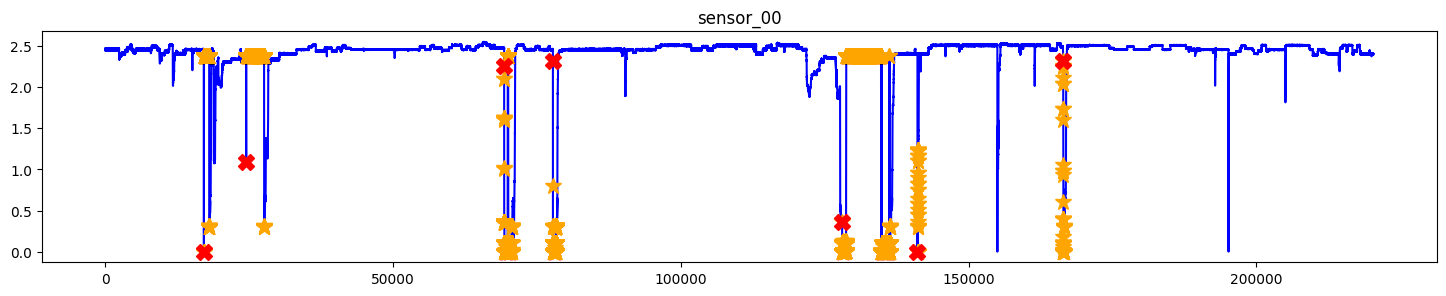

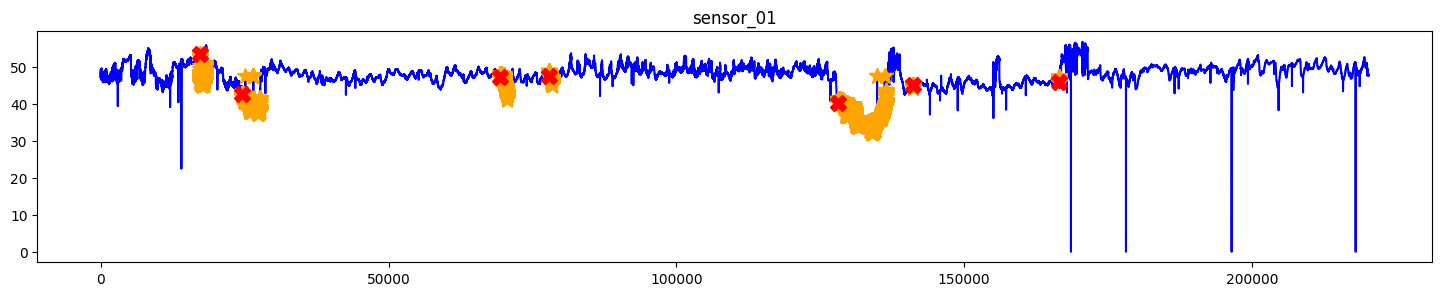

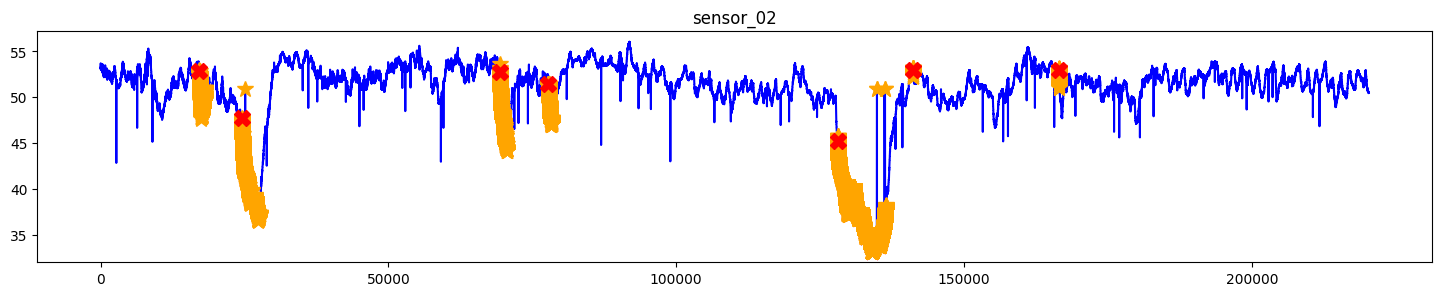

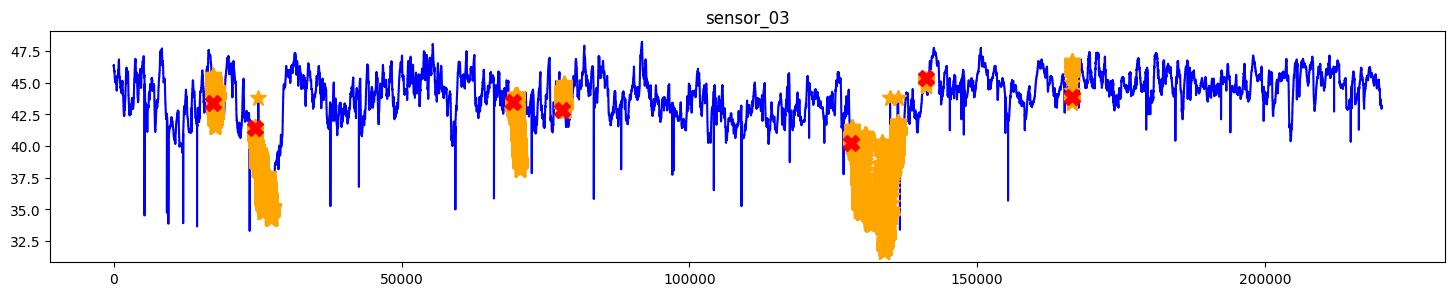

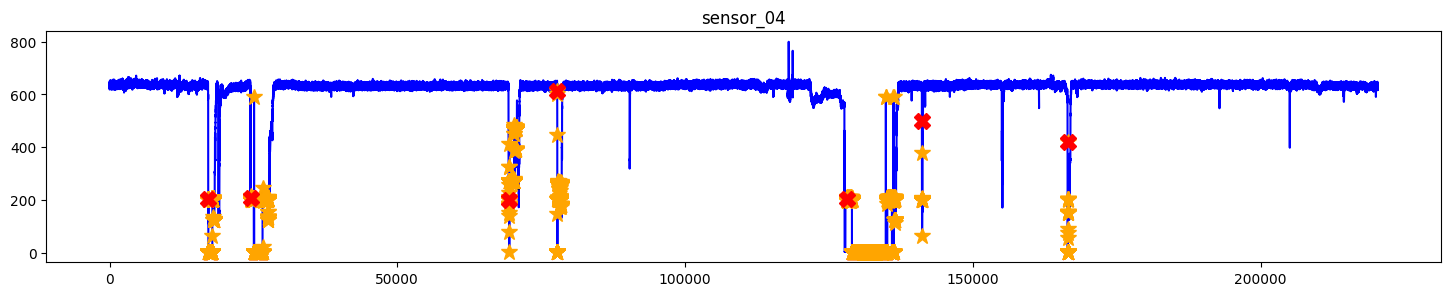

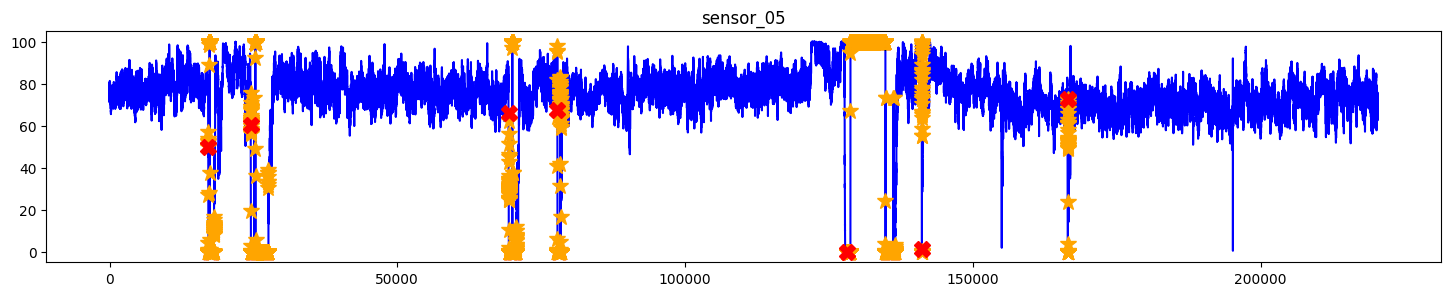

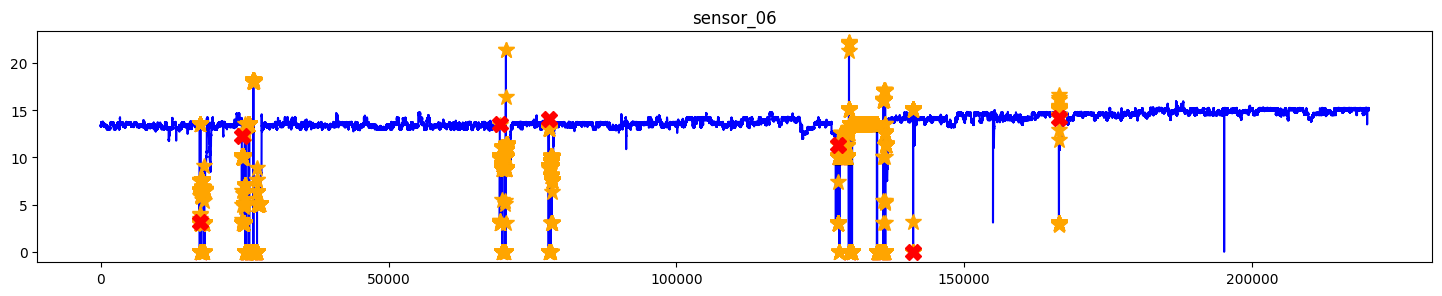

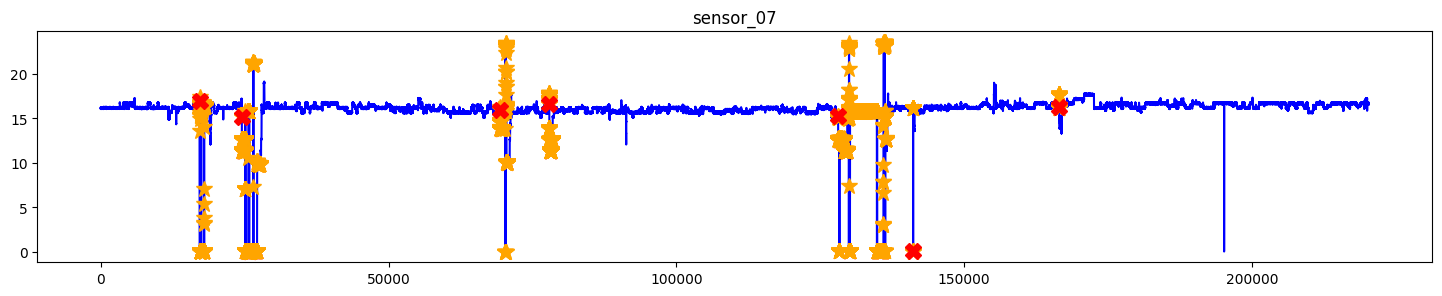

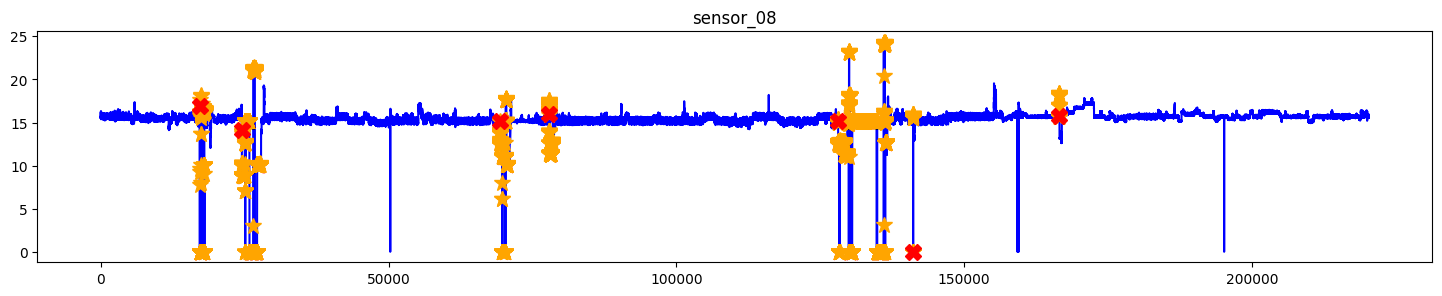

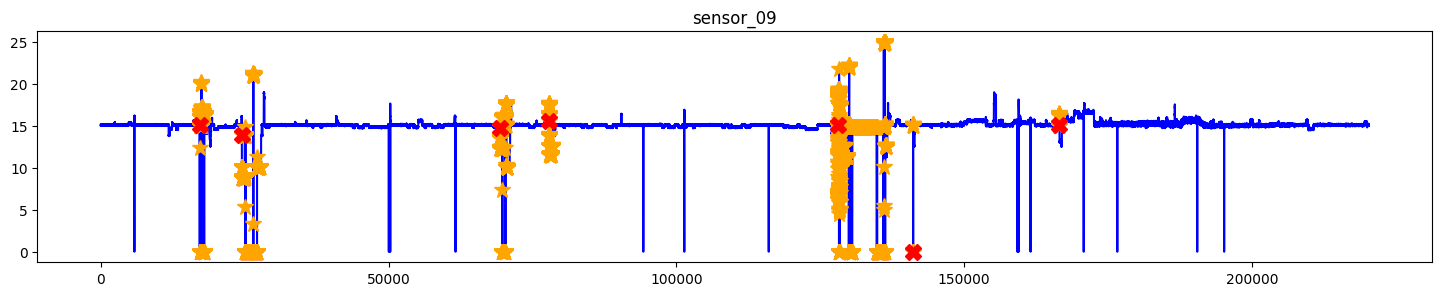

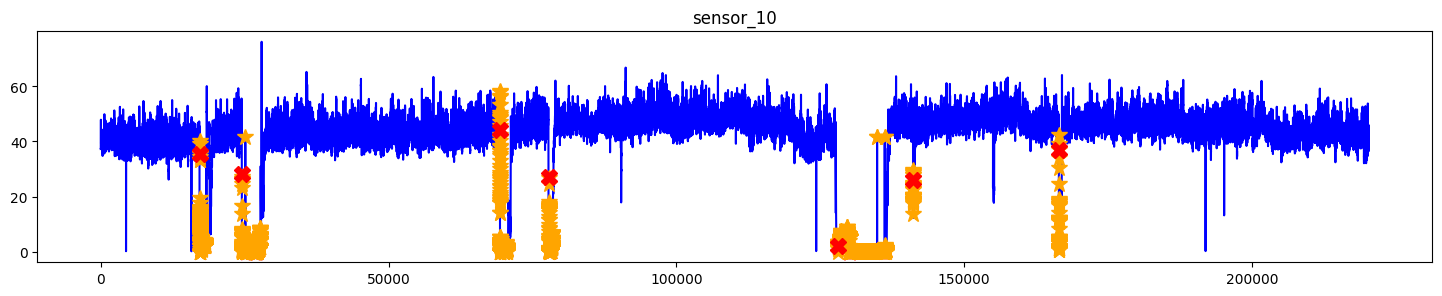

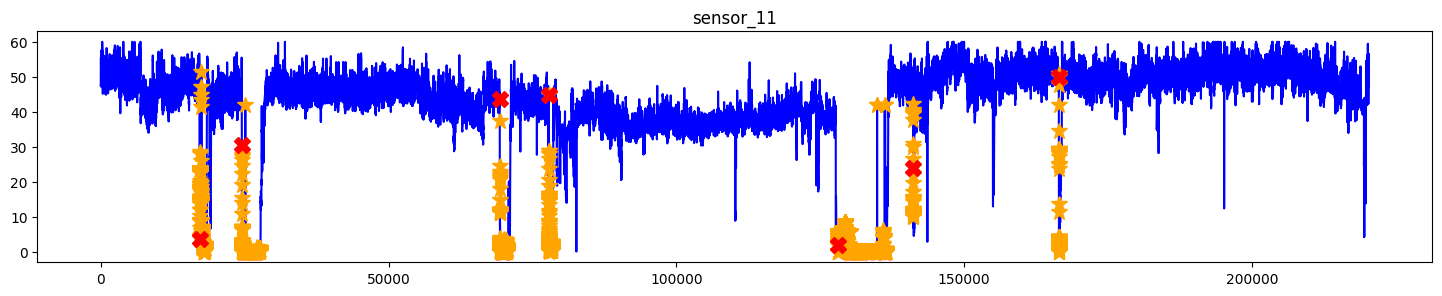

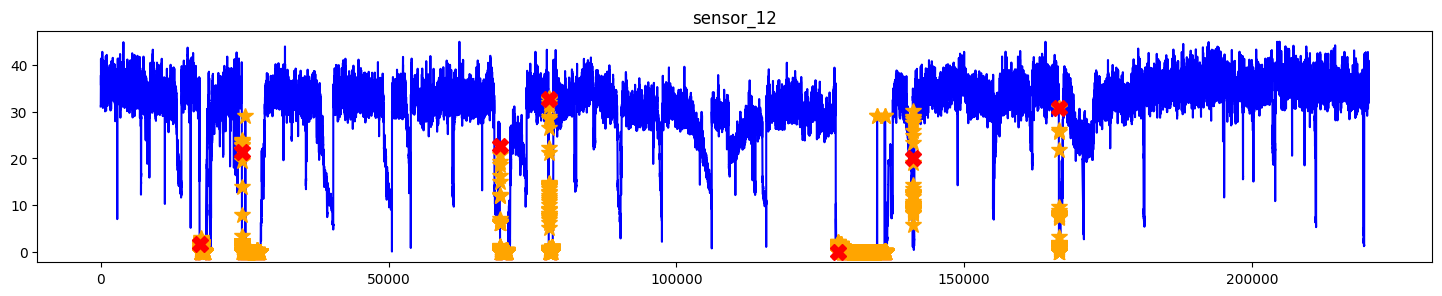

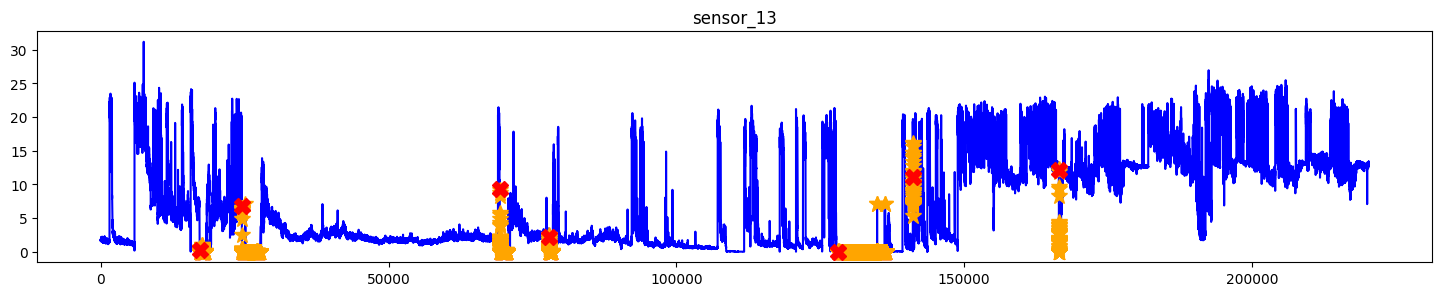

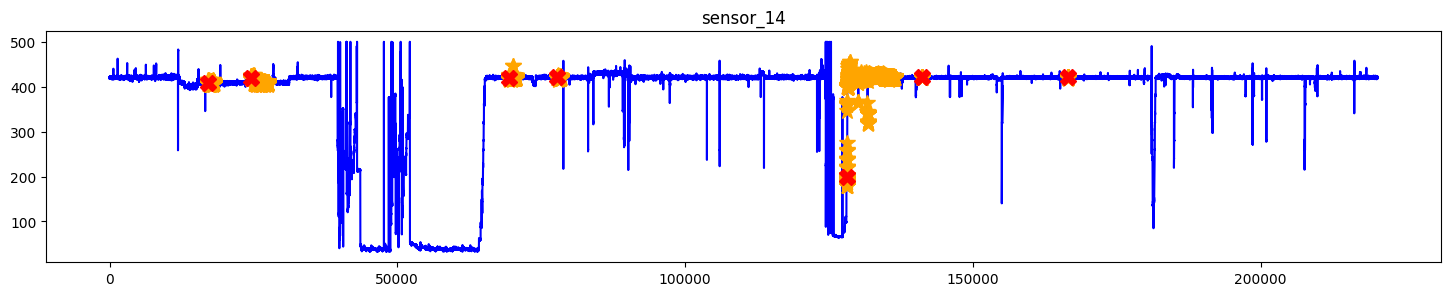

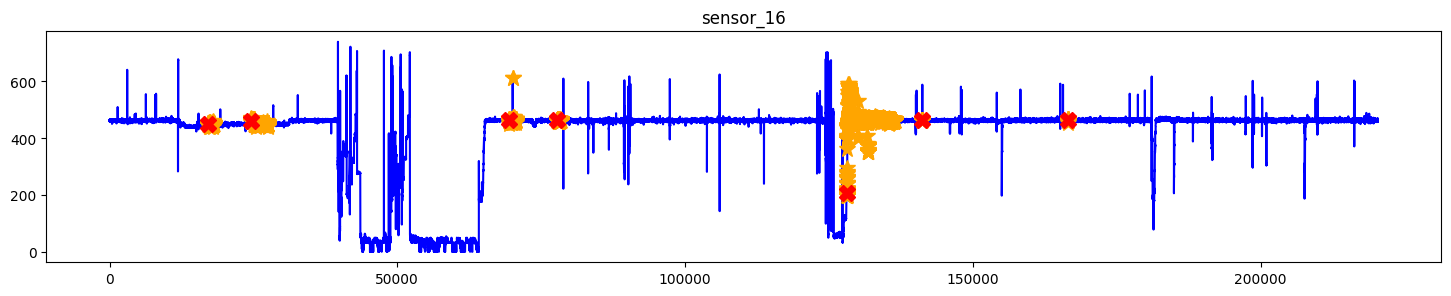

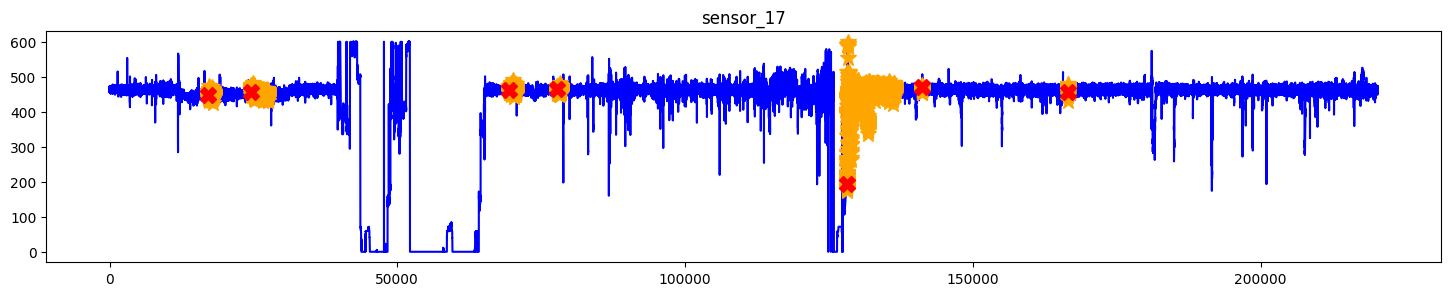

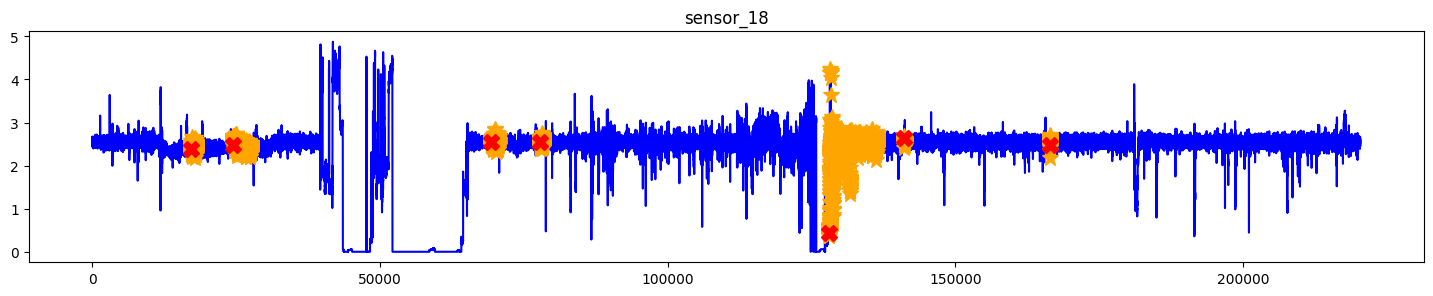

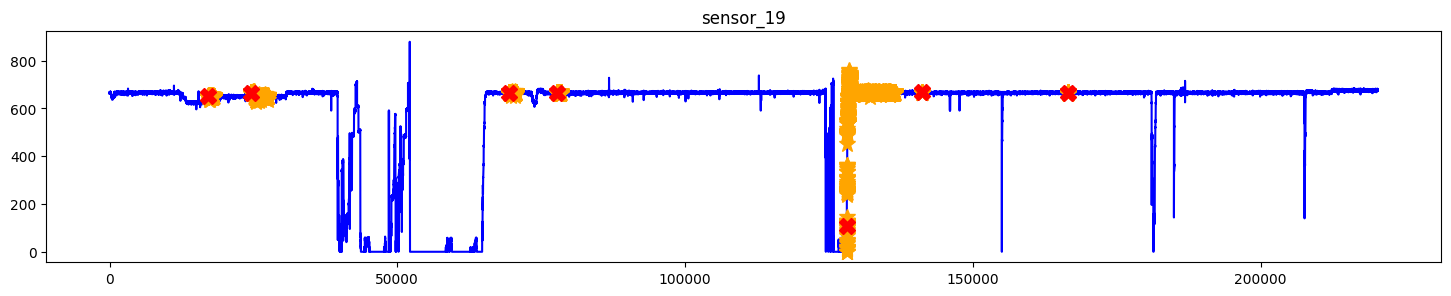

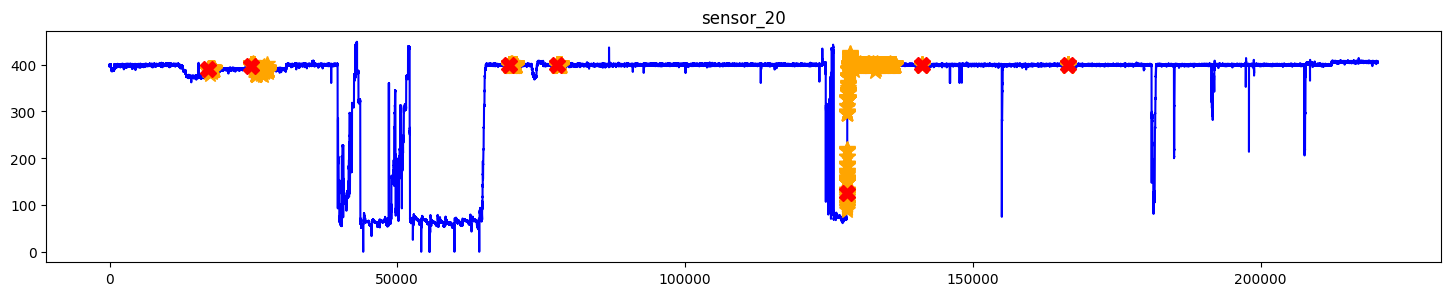

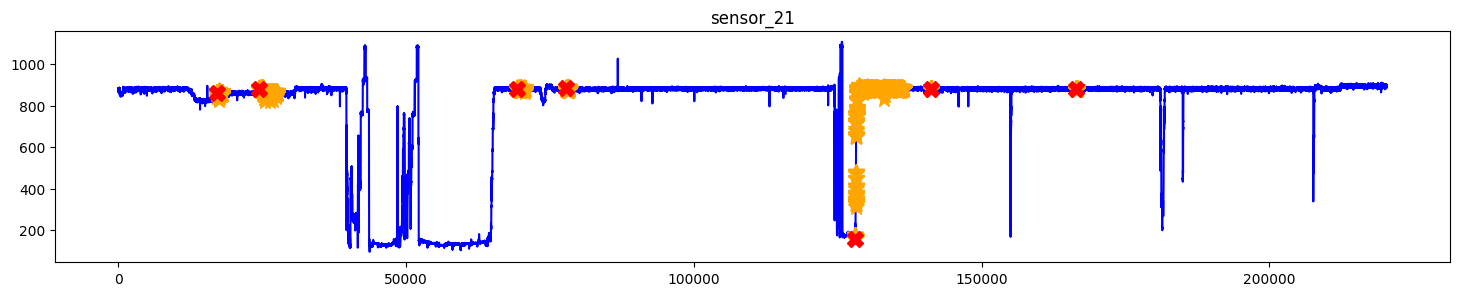

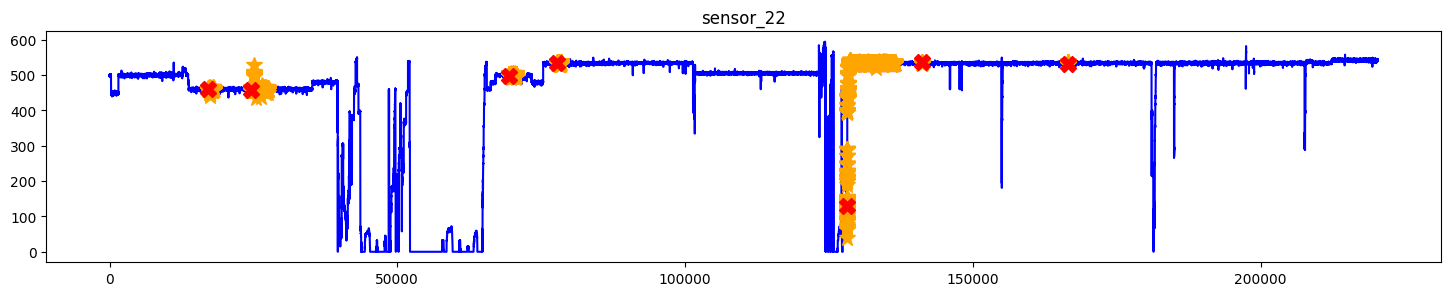

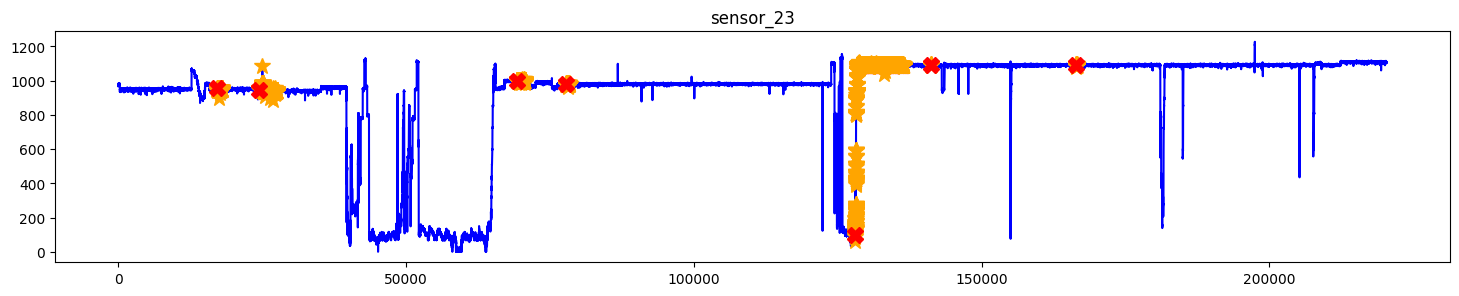

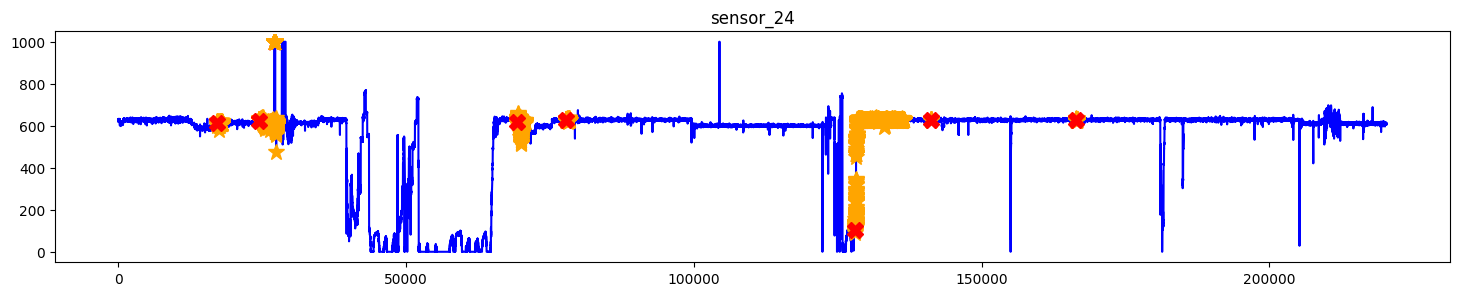

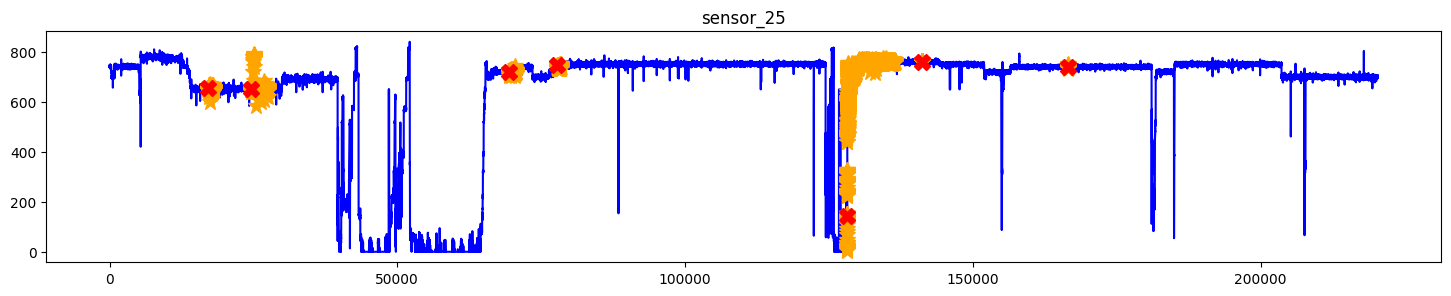

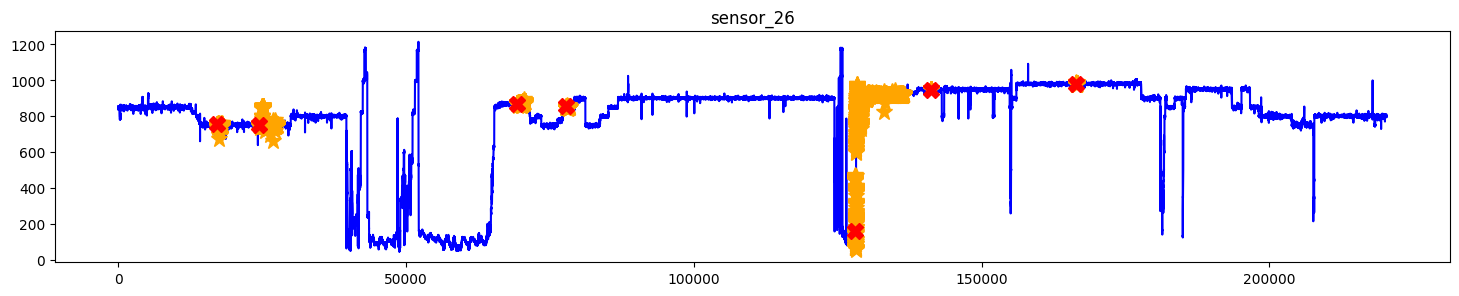

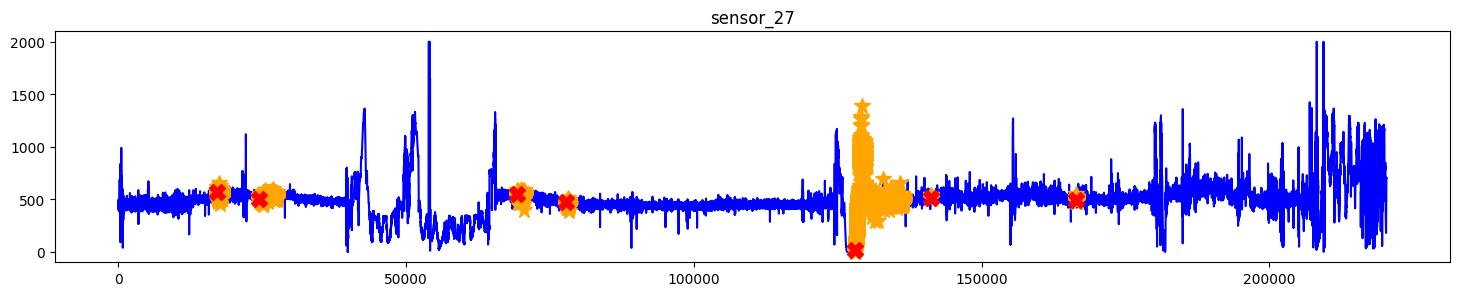

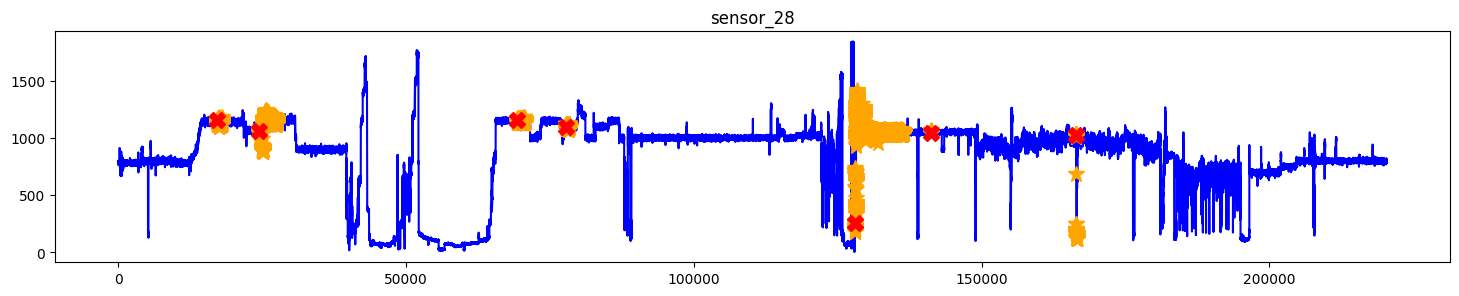

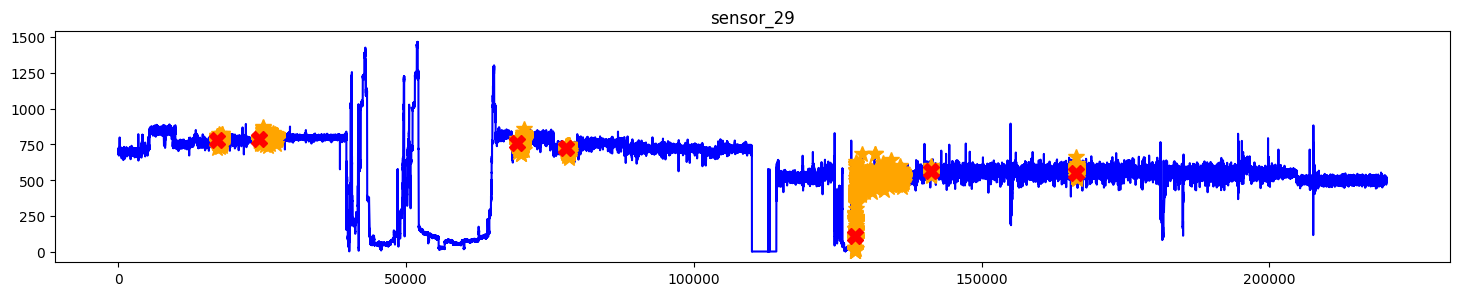

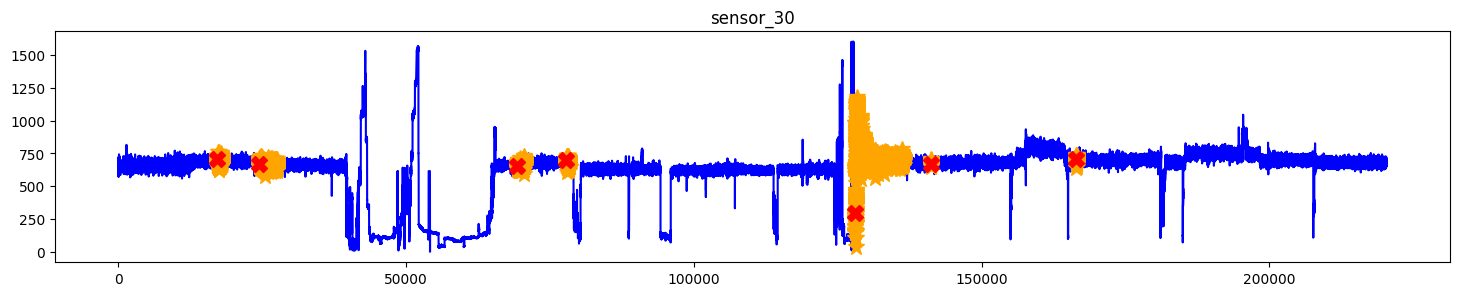

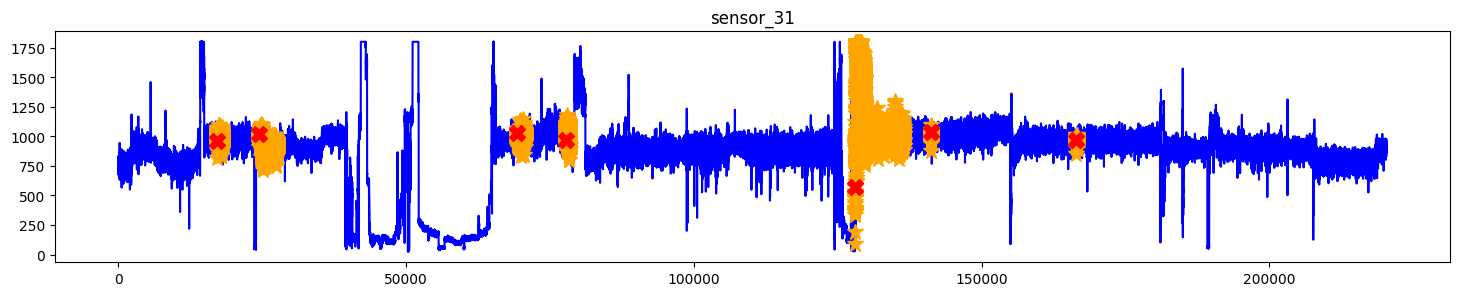

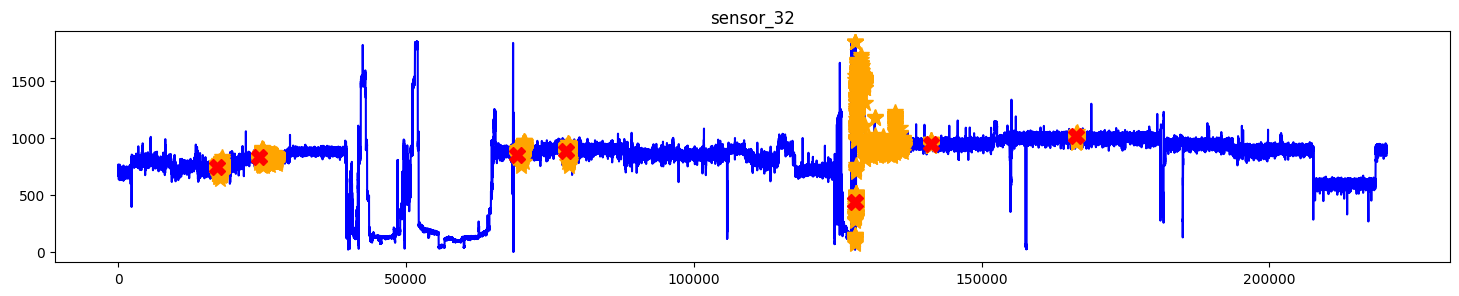

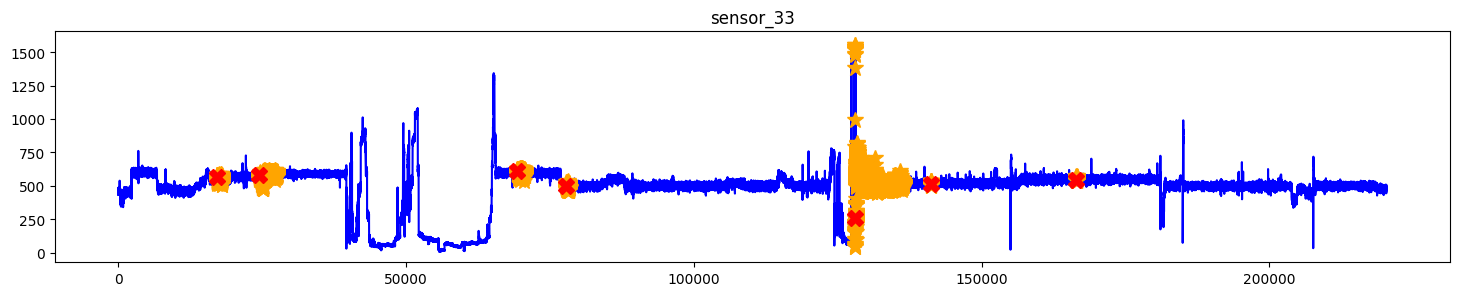

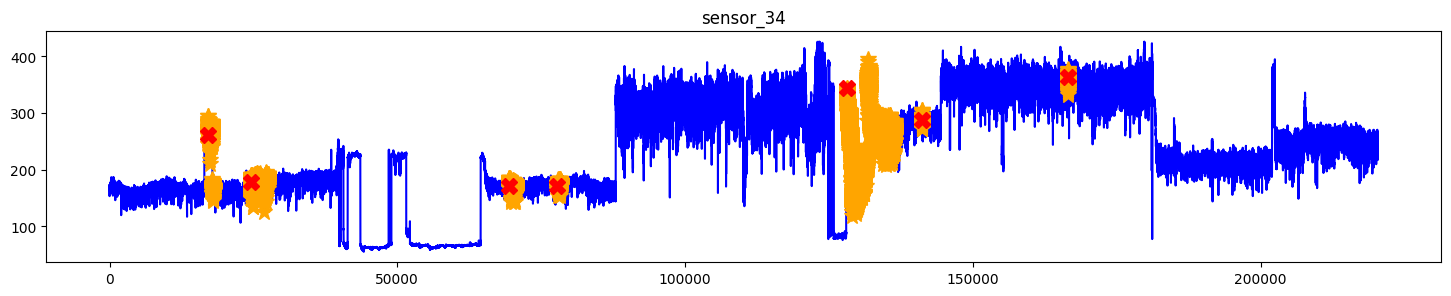

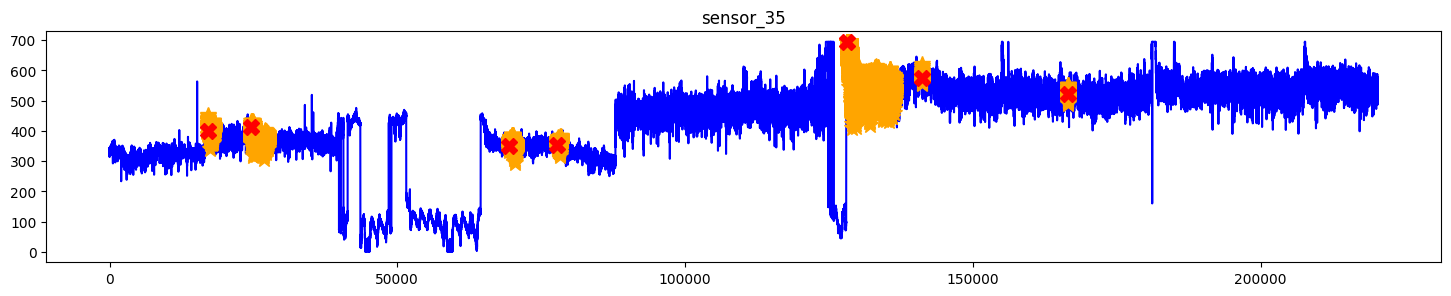

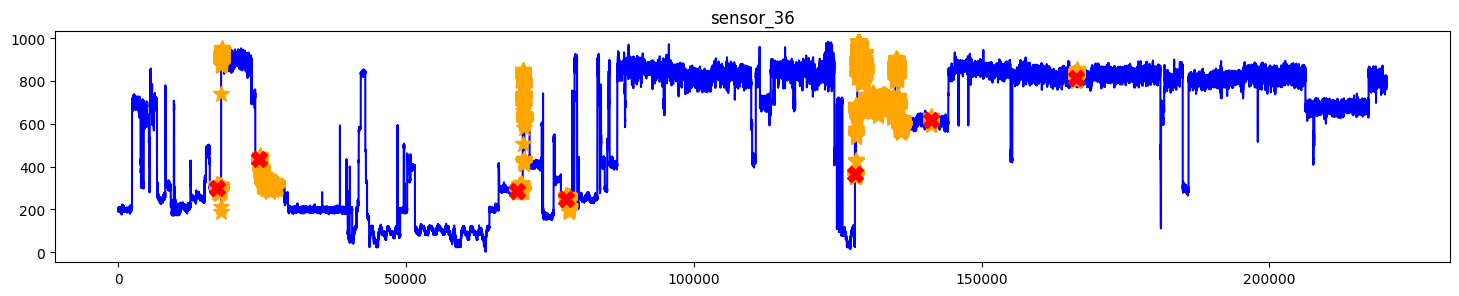

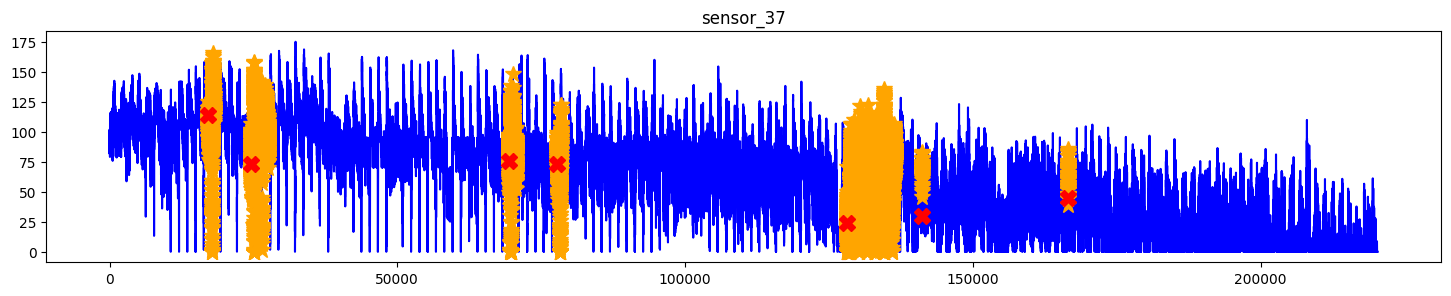

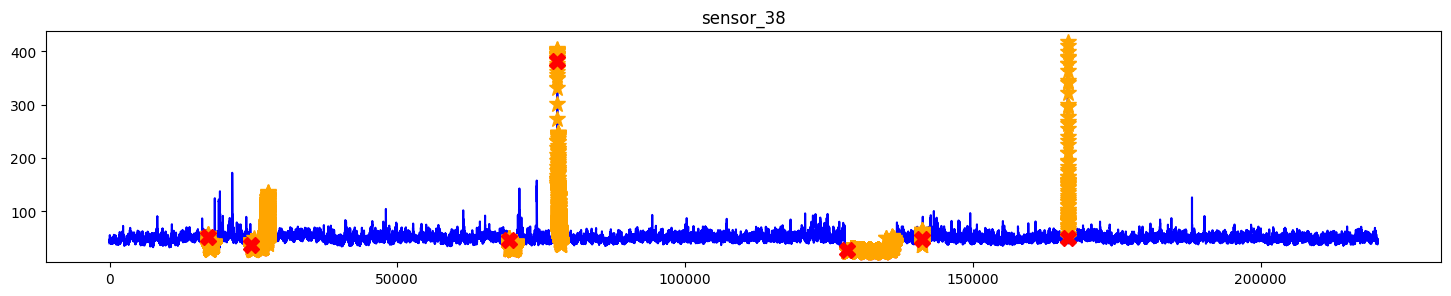

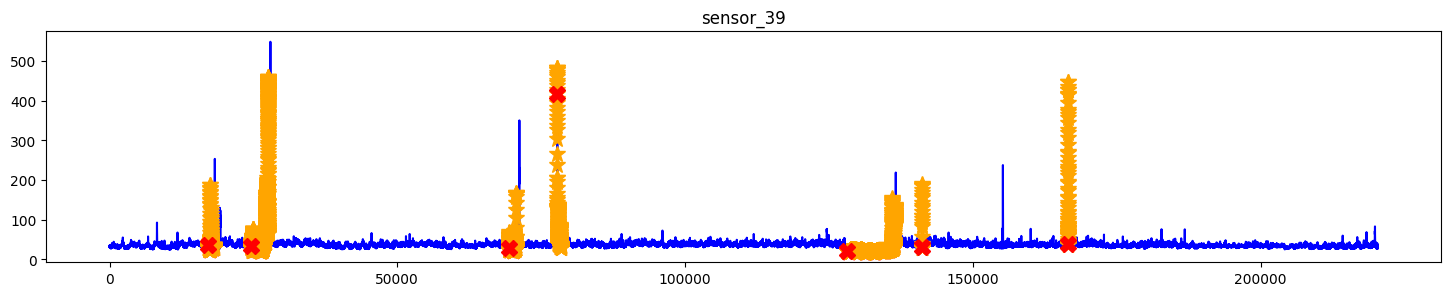

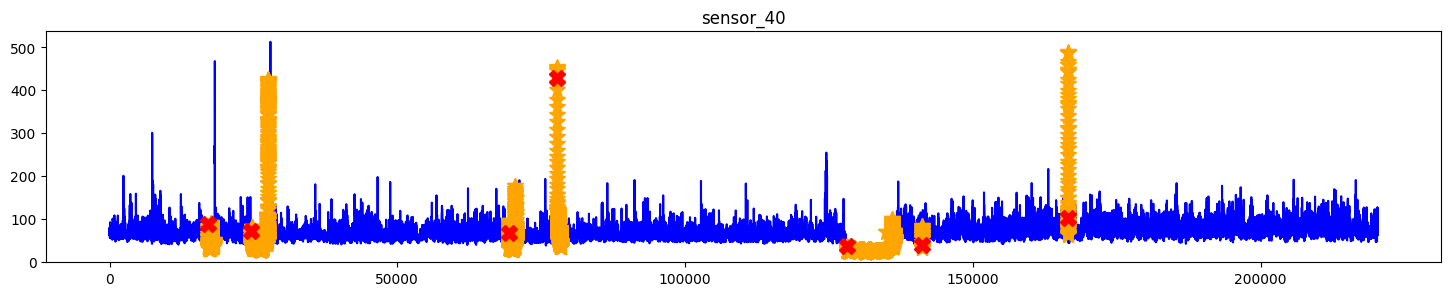

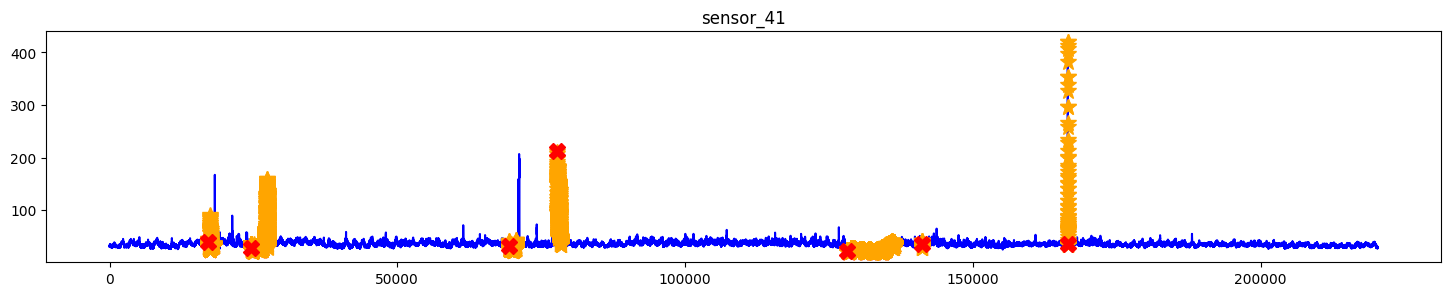

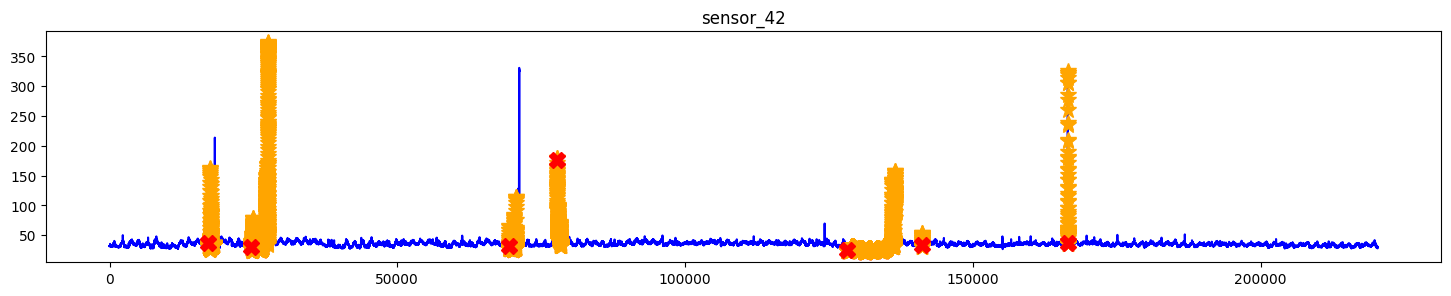

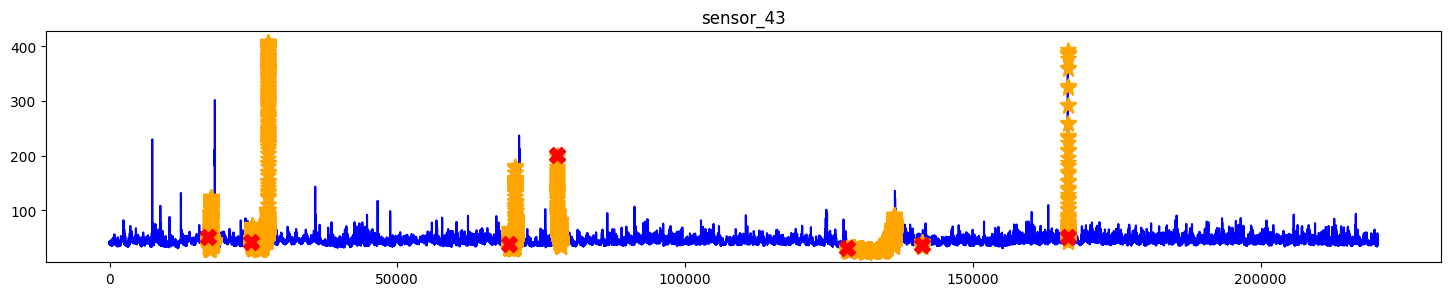

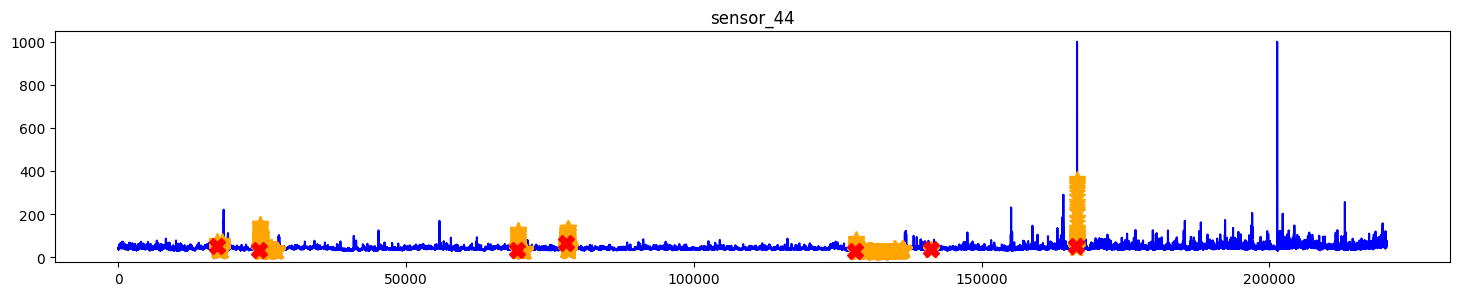

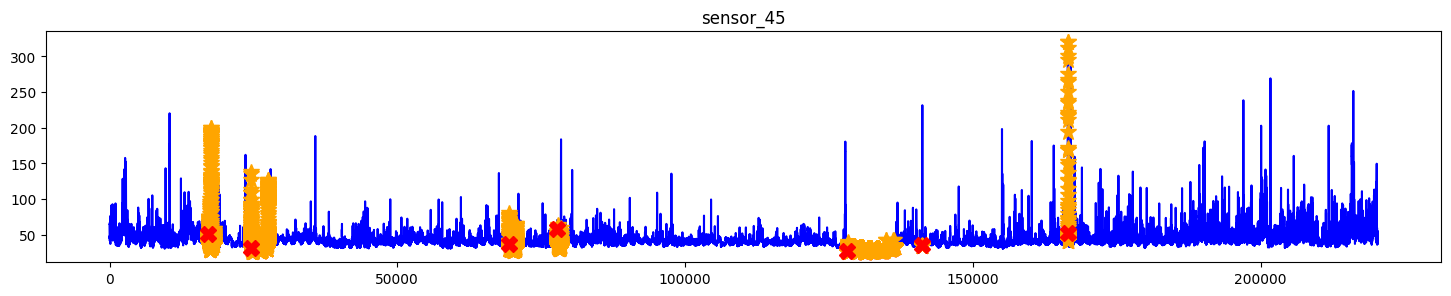

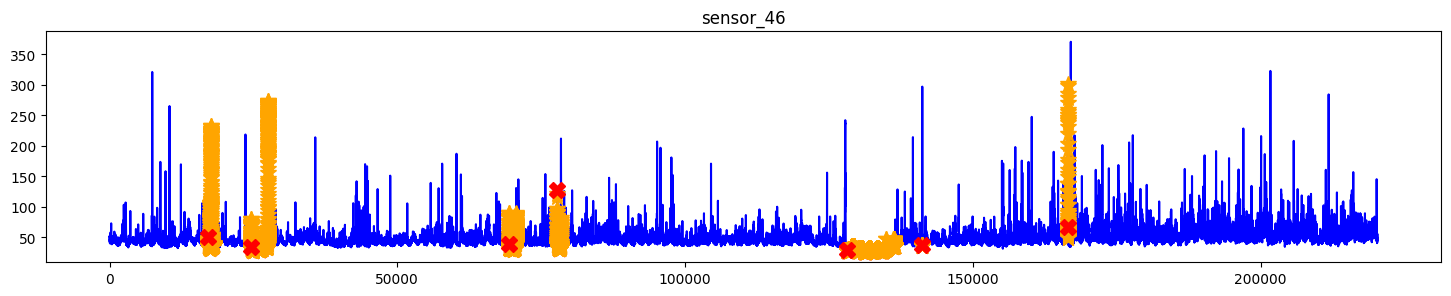

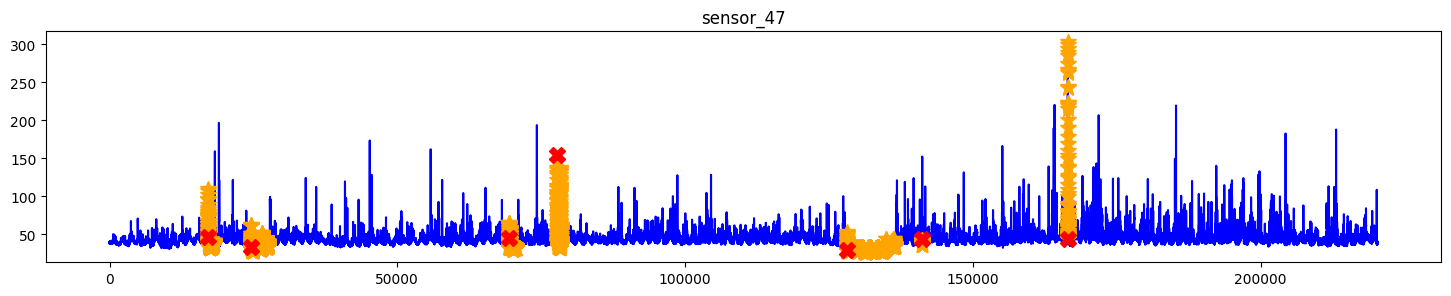

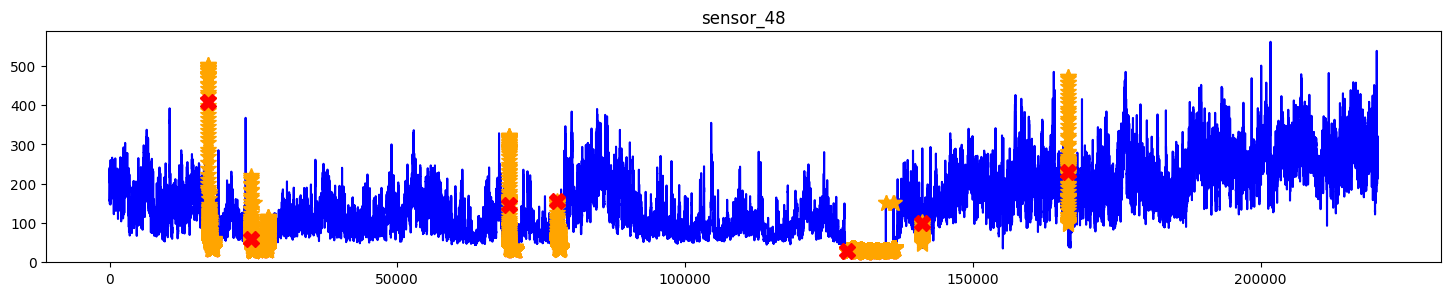

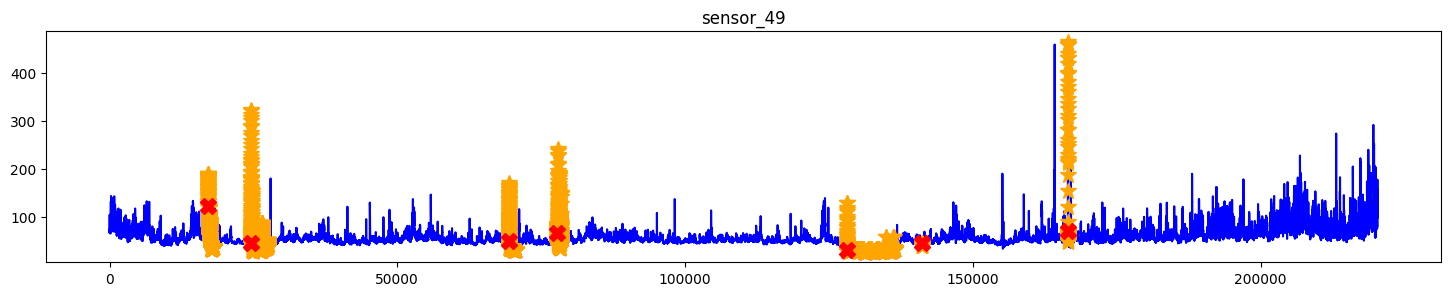

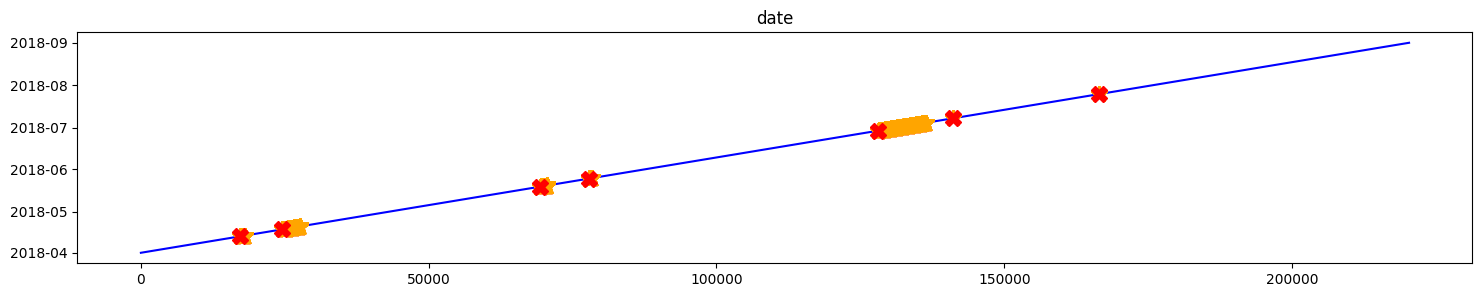

In [17]:
# Extract the readings from the BROKEN state of the pump
broken = df_tidy[df_tidy['machine_status']=='BROKEN']
recovr = df_tidy[df_tidy['machine_status']=='RECOVERING']

# Extract the names of the numerical columns
df_features = df_tidy.drop(['machine_status'], axis=1)
feature_names = df_features.columns

# Plot time series for each sensor with BROKEN state marked with X in red color
for name in feature_names:
    _ = plt.figure(figsize=(18,3))    
    _ = plt.plot(df_tidy[name], color='blue')    
    _ = plt.plot(recovr[name], linestyle='none', marker='*', color='orange', markersize=12)
    _ = plt.plot(broken[name], linestyle='none', marker='X', color='red', markersize=12)
    _ = plt.title(name)
    plt.show()

As seen clearly from the above plot, the red marks, which represent the broken state of the pump, perfectly overlaps with the observed disturbances of the sensor reading. **Now we have a pretty good intuition about how each of the sensor reading behaves when the pump is broken vs operating normally**.

<a id='sect2_3'></a>
### <font color='darkgreen'>Stationarity and Autocorrelation</font>
<font size='3ptx'>**In time series analysis, it is important that the data is stationary and have no autocorrelation**</font>. **<font color='darkblue'>Stationarity</font> refers to the behavior where the mean and standard deviation of the data changes over time, the data with such behavior is considered not stationary**. On the other hand, **<font color='darkblue'>autocorrelation</font> refers to the behavior of the data where the data is correlated with itself in a different time period.** As the next step, I will visually inspect the stationarity of each feature in the data set and the following code will do just that. **Later, we will also perform the Dickey Fuller test to quantitatively verify the observed stationarity. In addition, we will inspect the autocorrelation of the features before feeding them into the clustering algorithms to detect anomalies.**

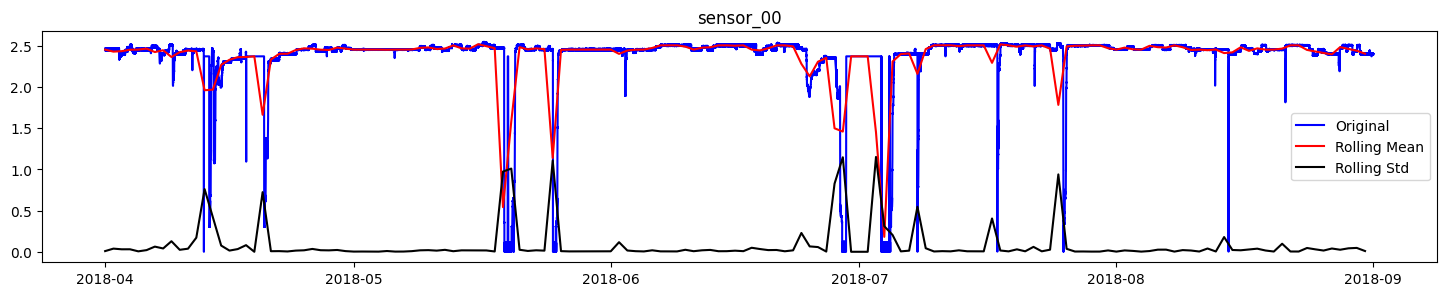

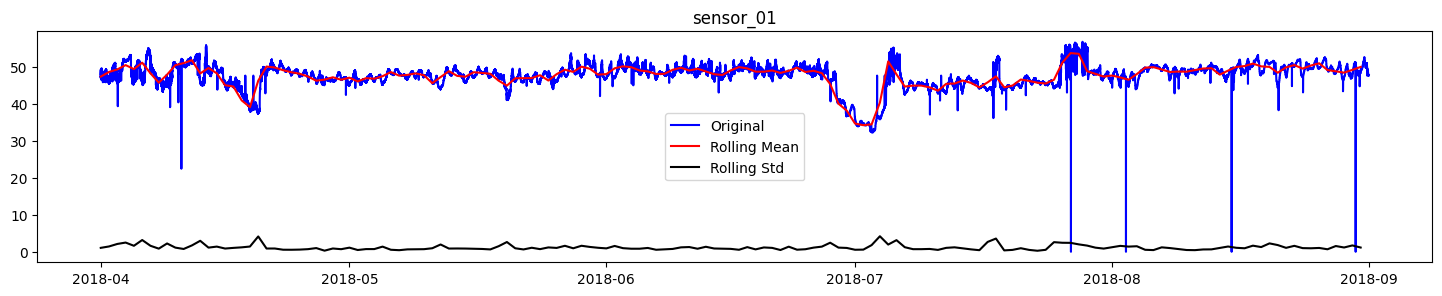

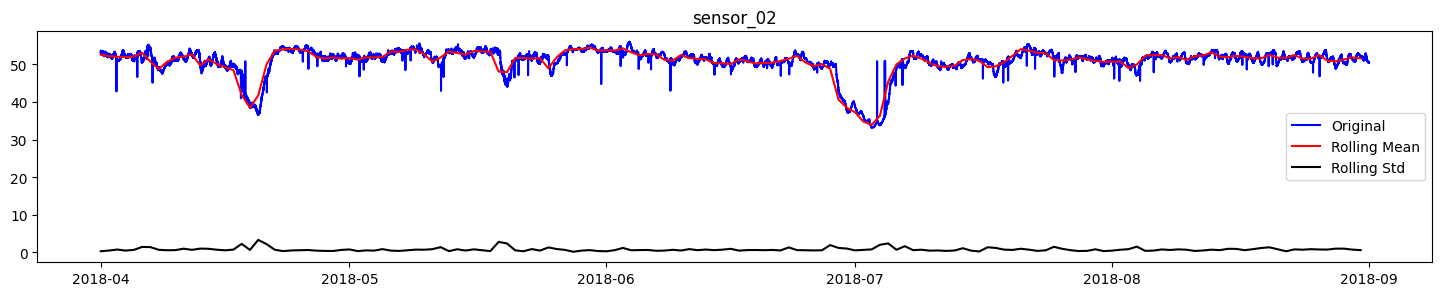

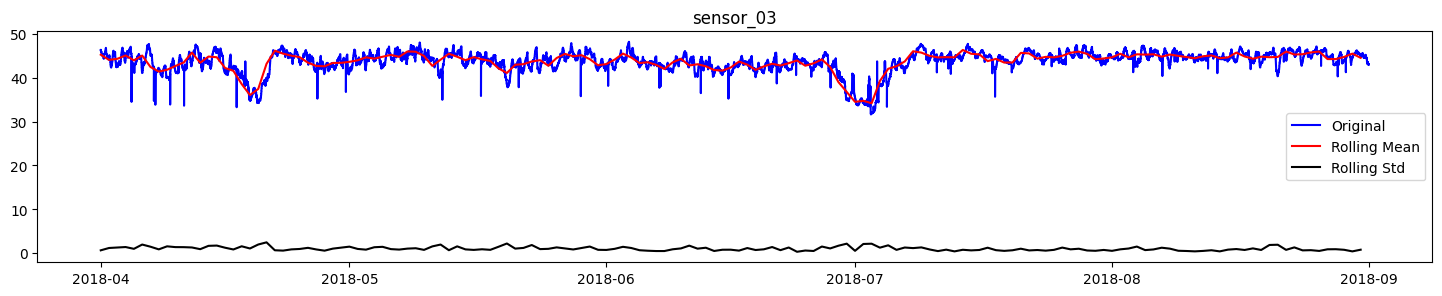

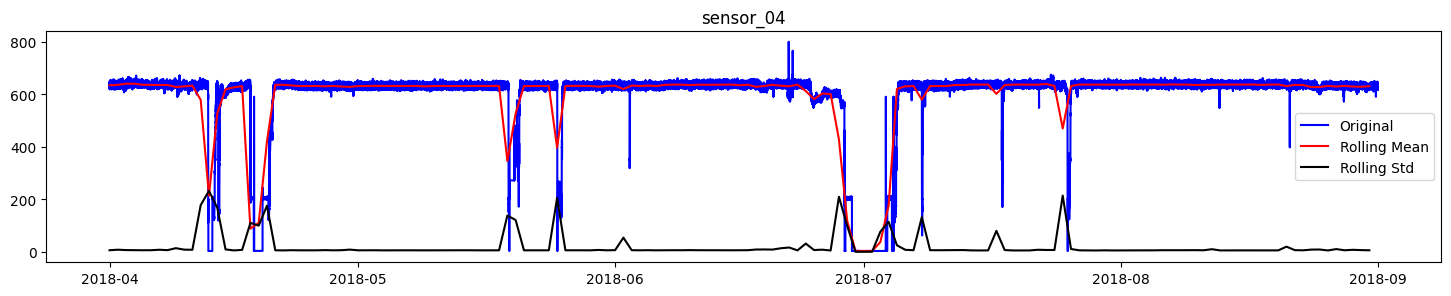

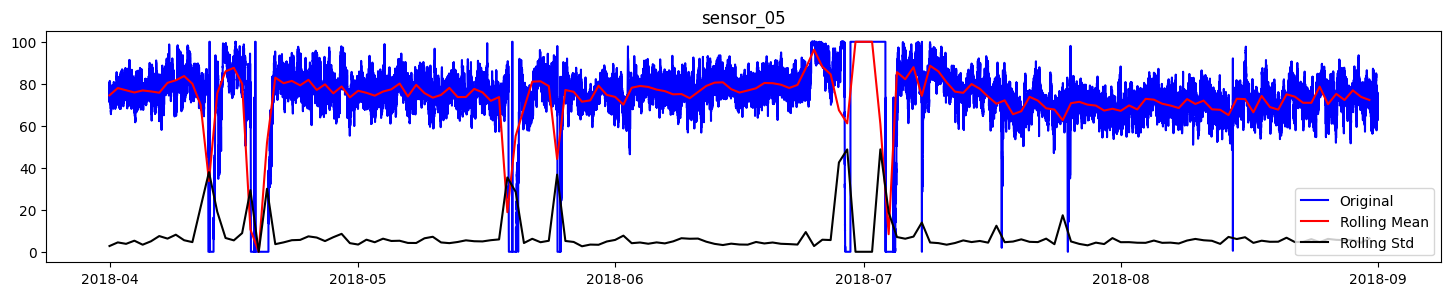

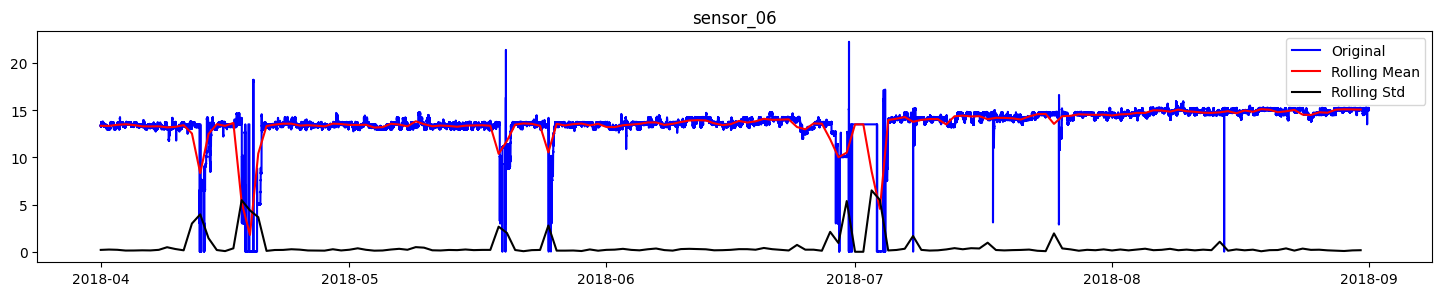

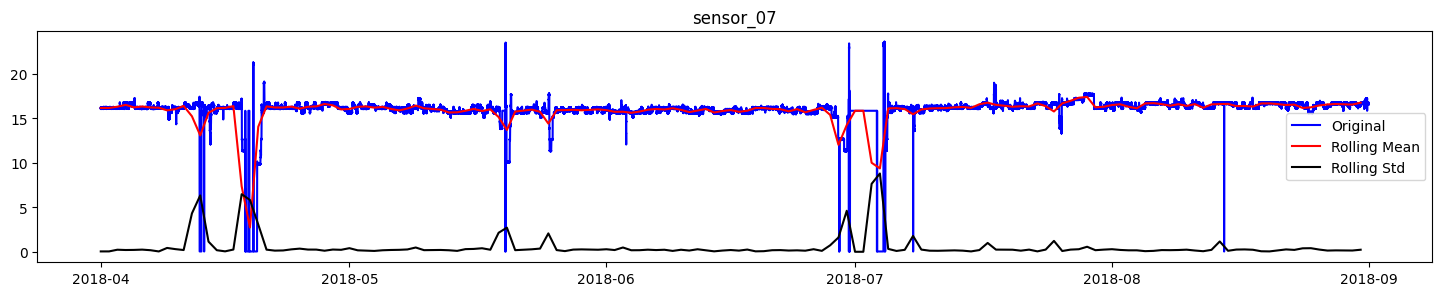

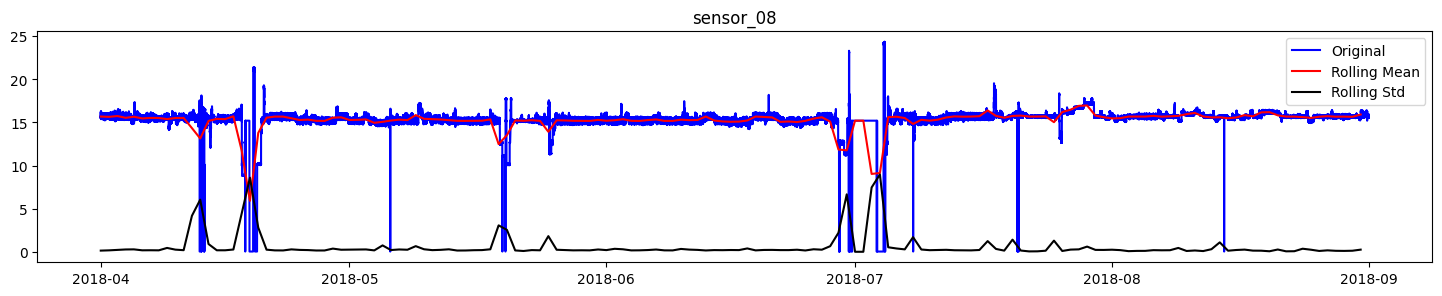

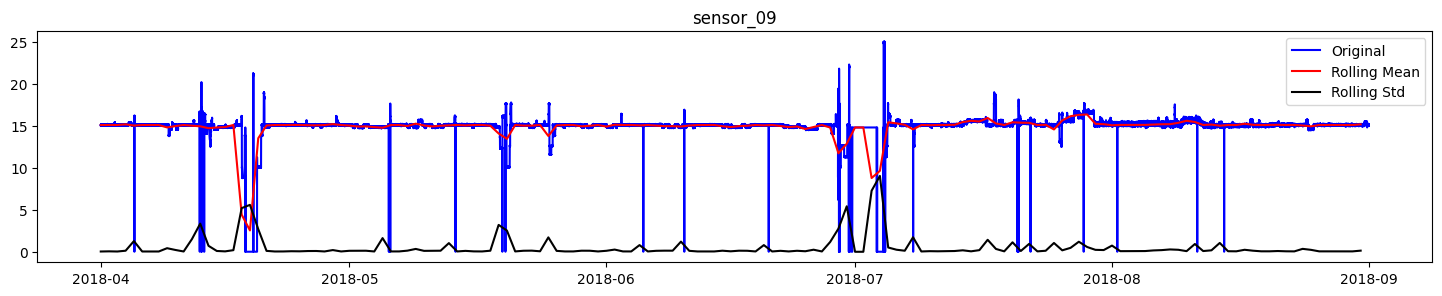

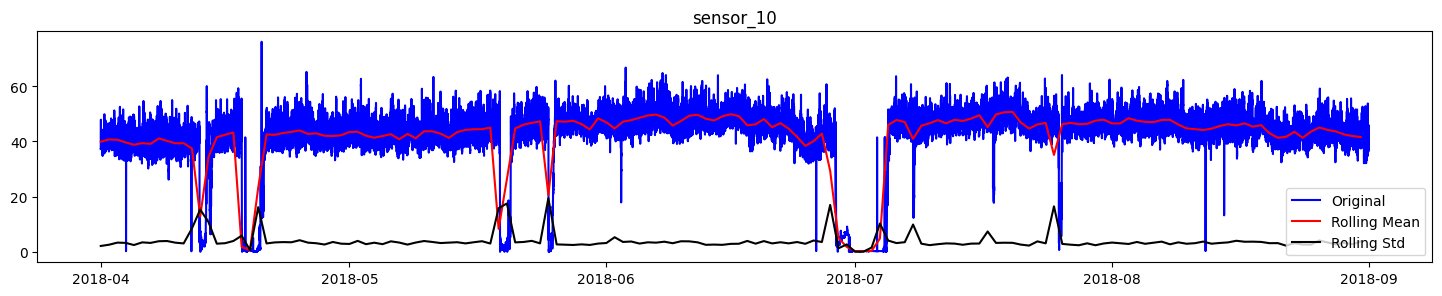

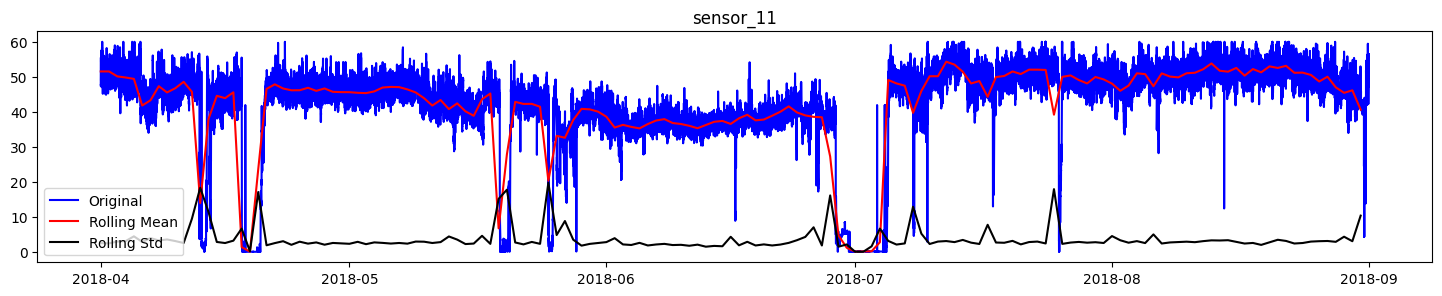

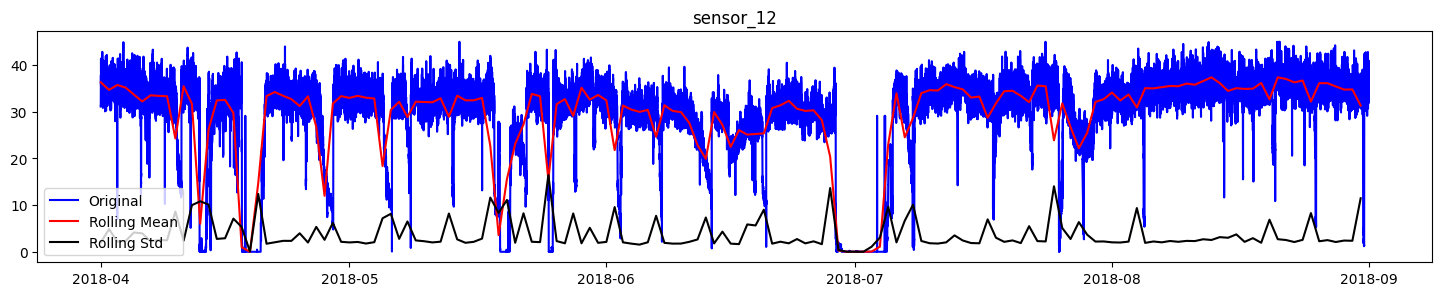

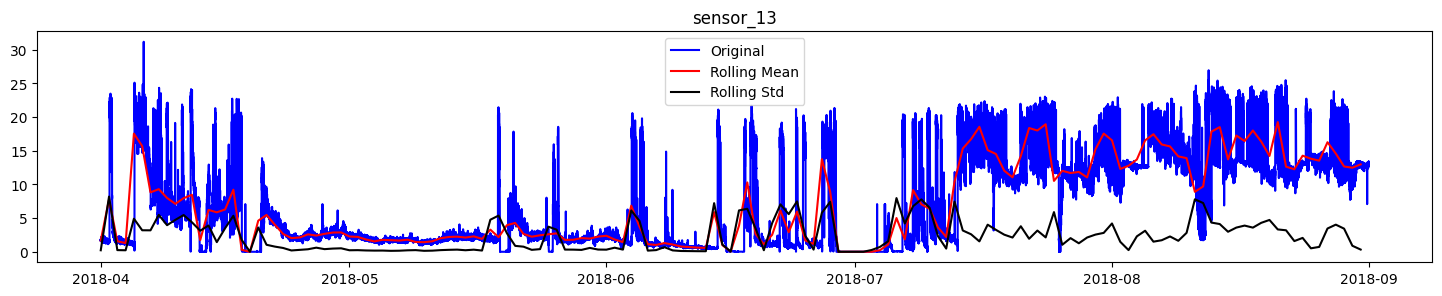

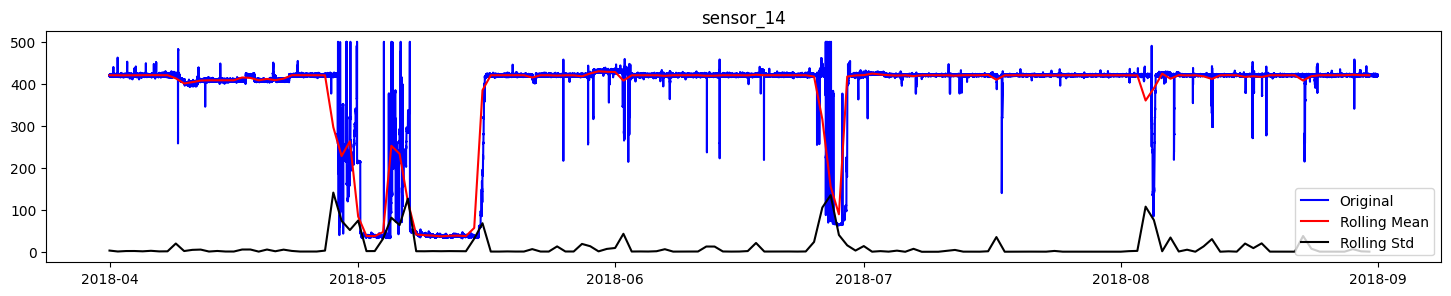

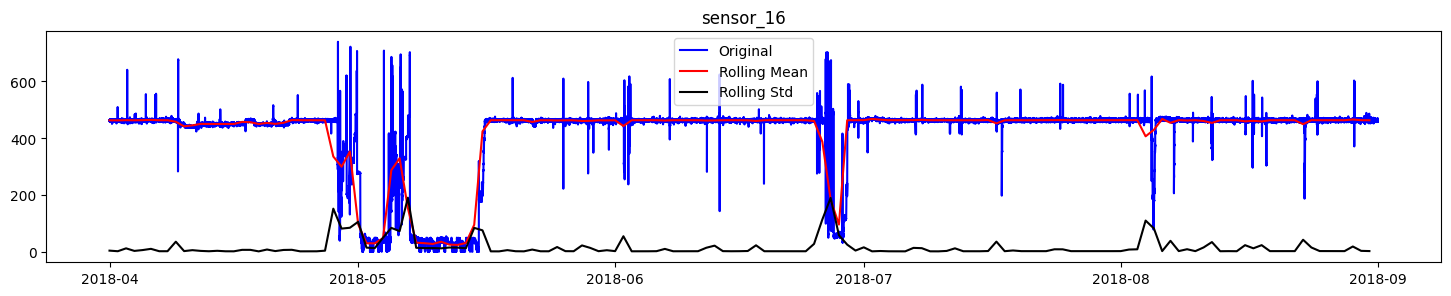

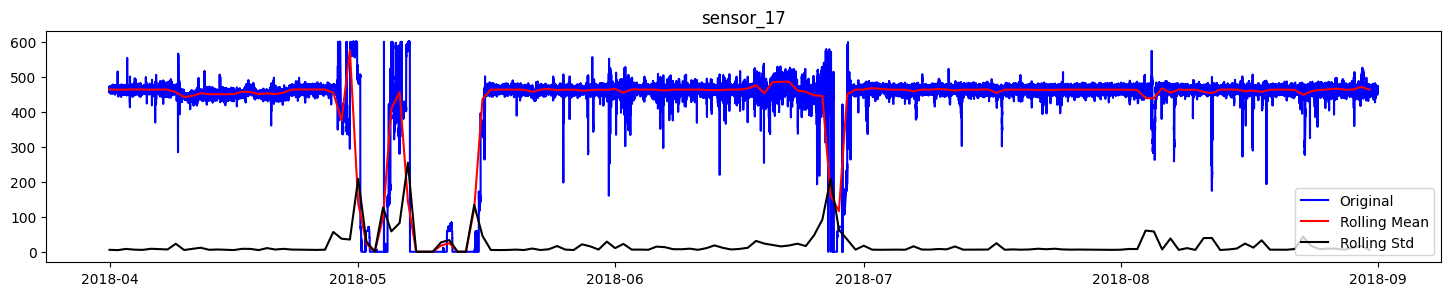

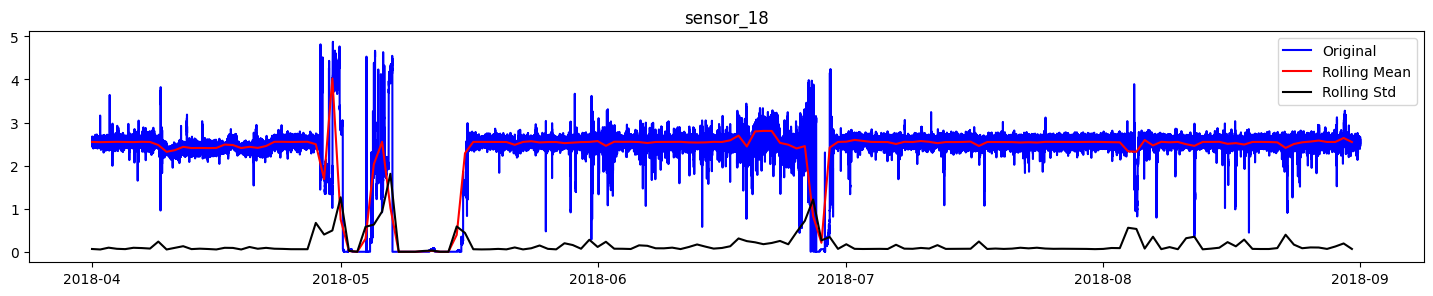

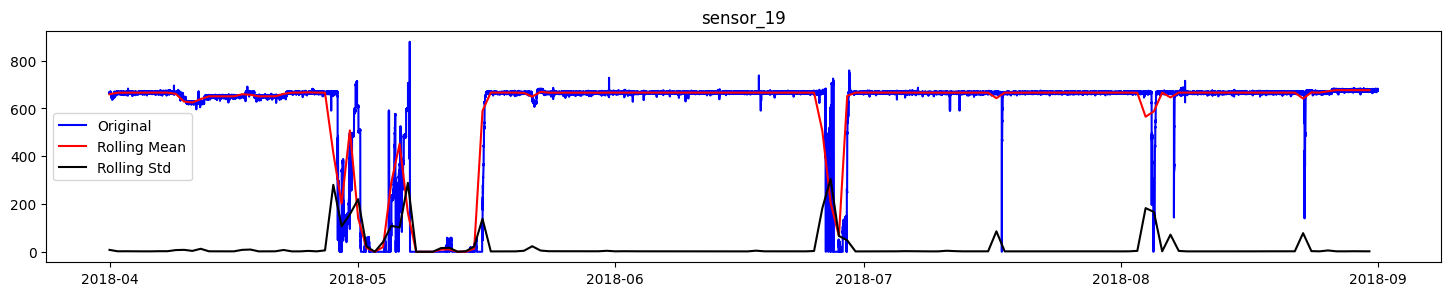

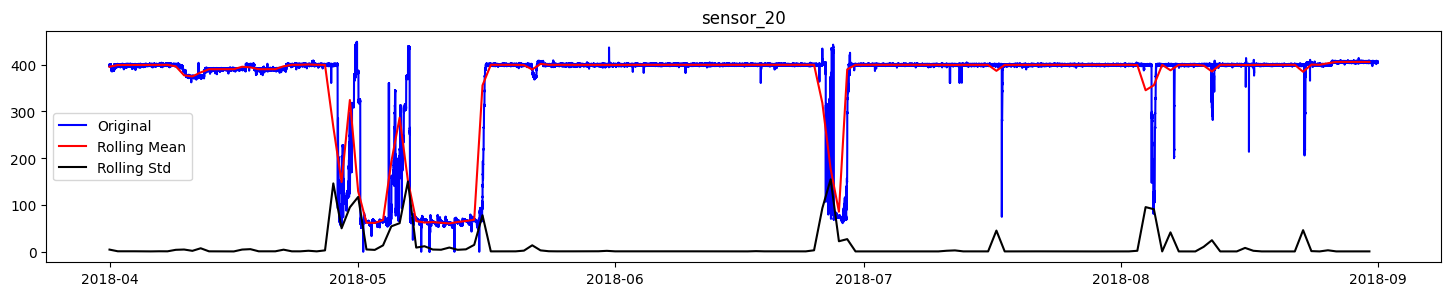

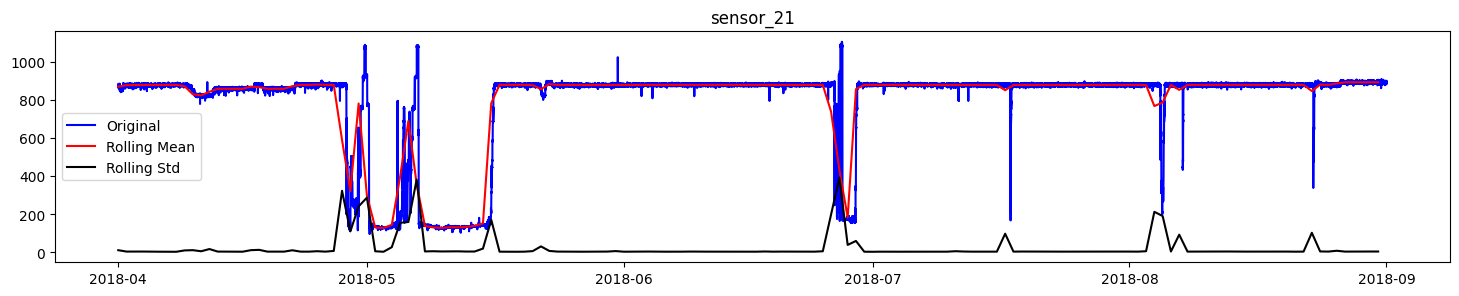

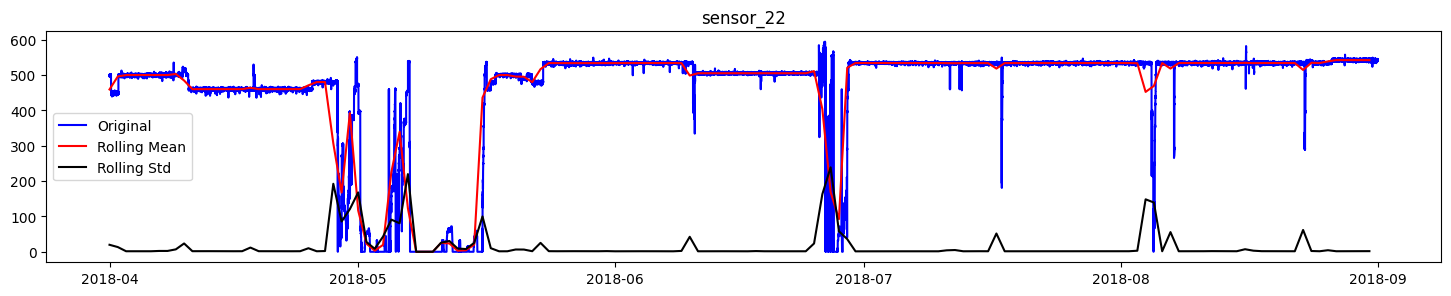

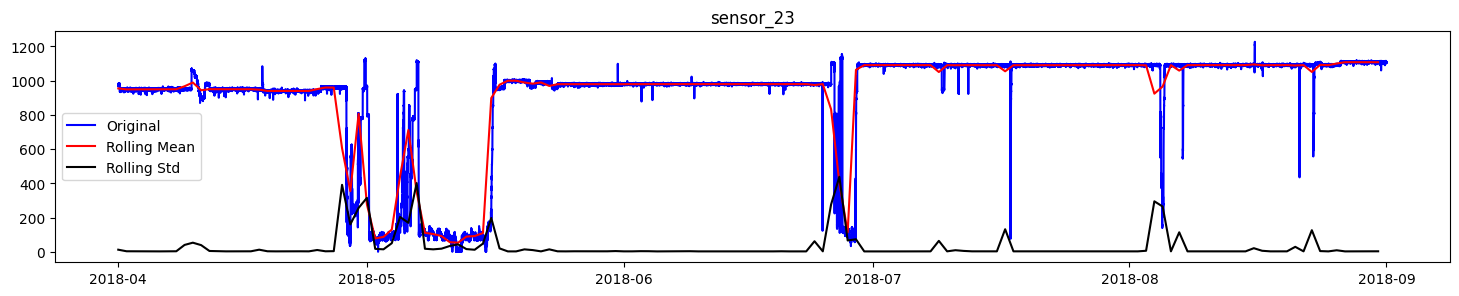

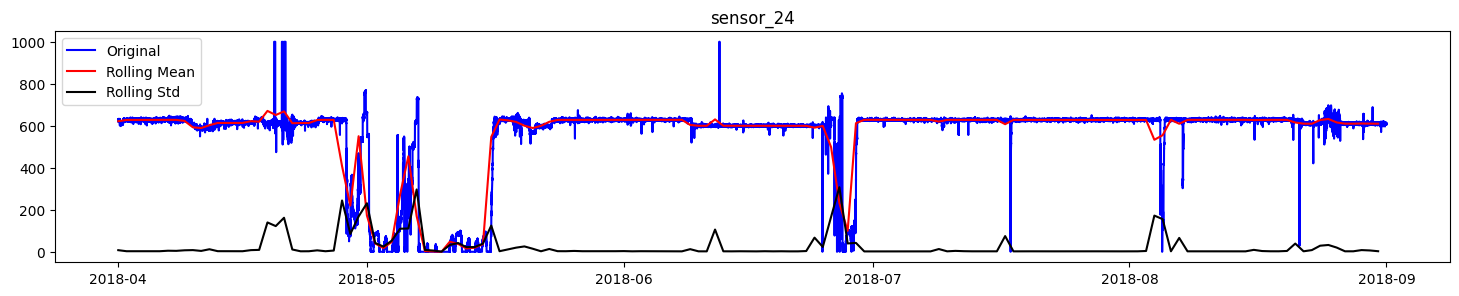

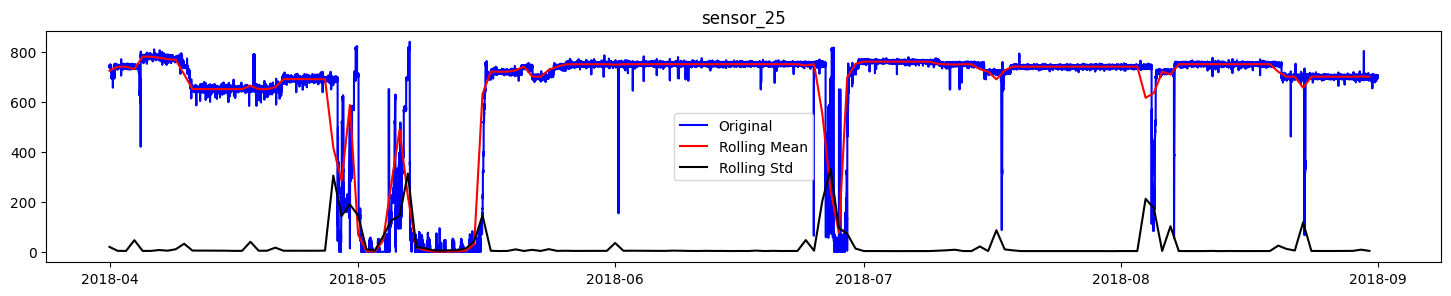

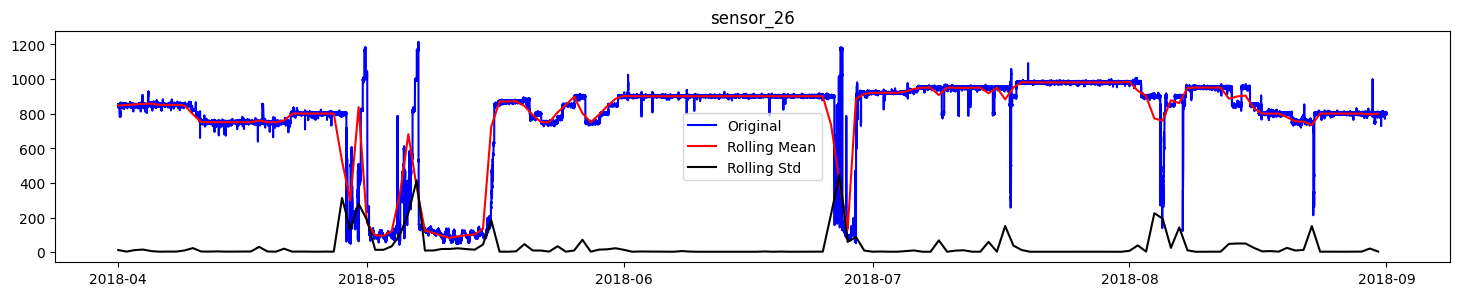

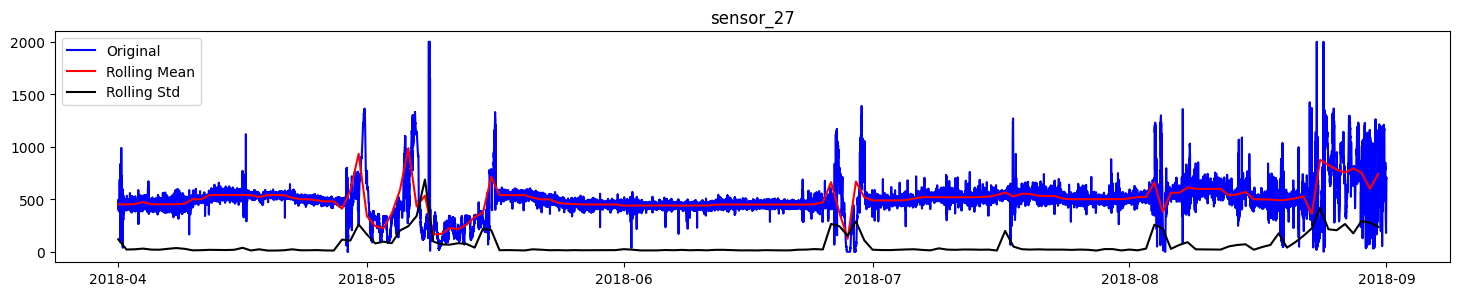

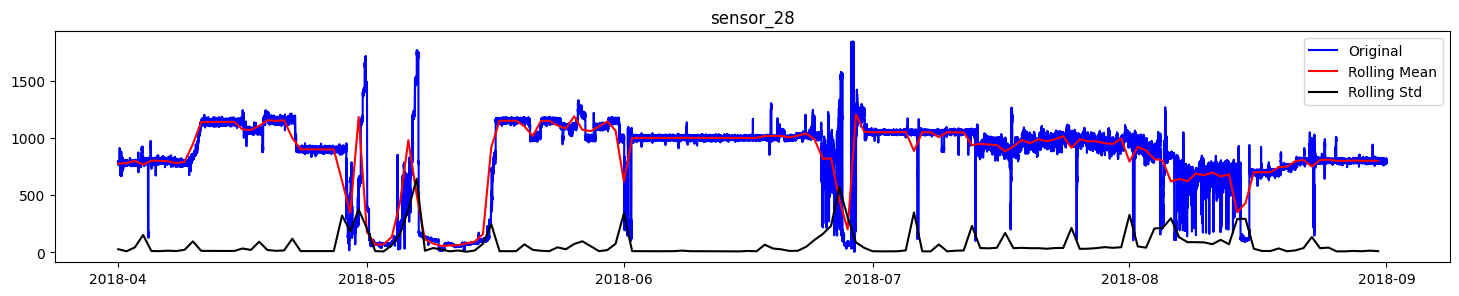

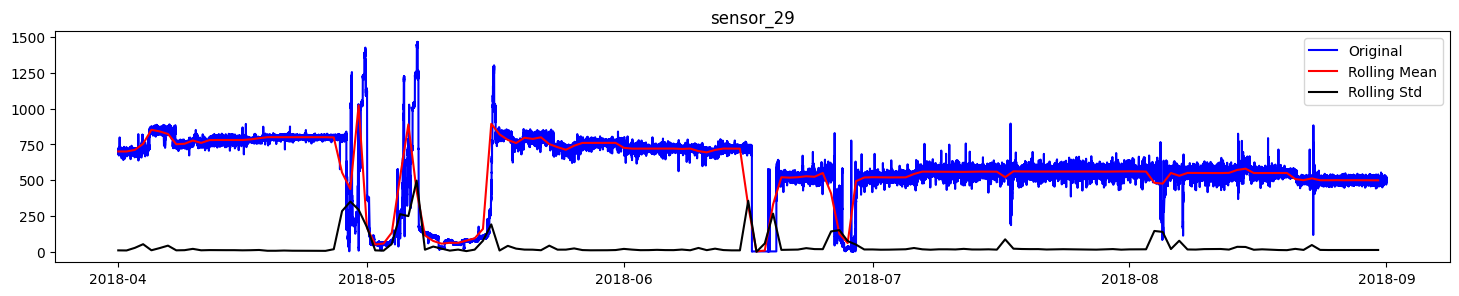

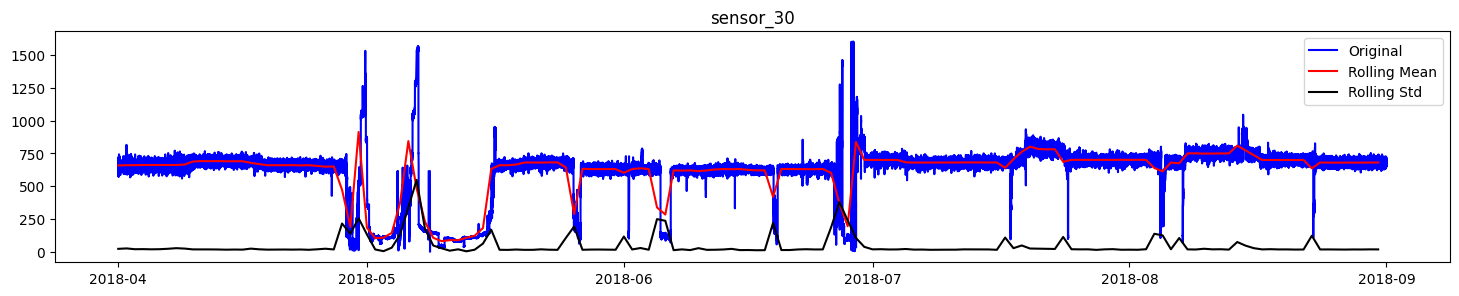

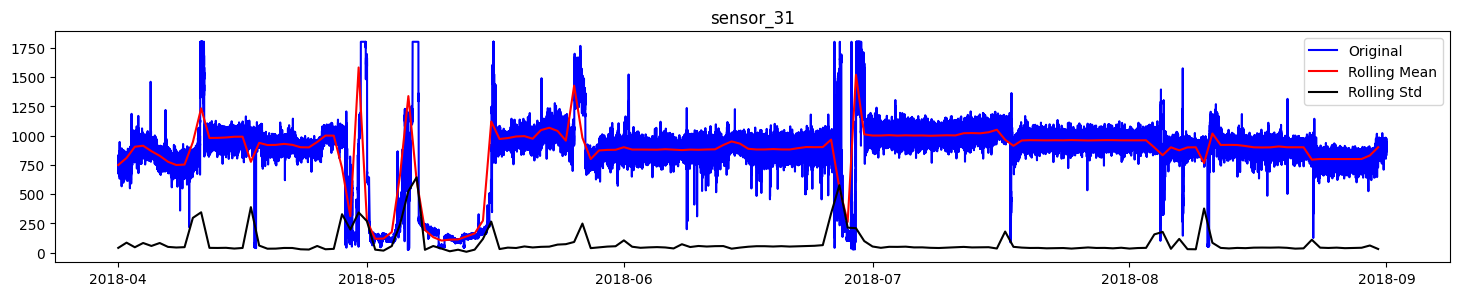

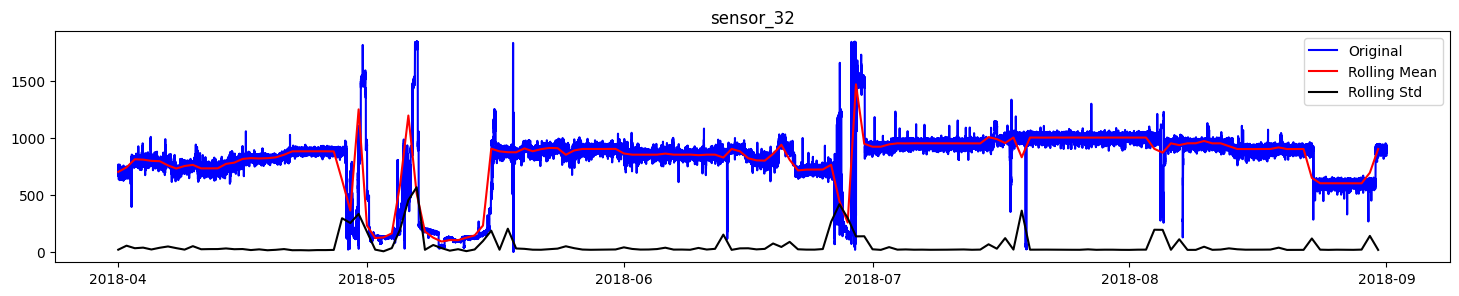

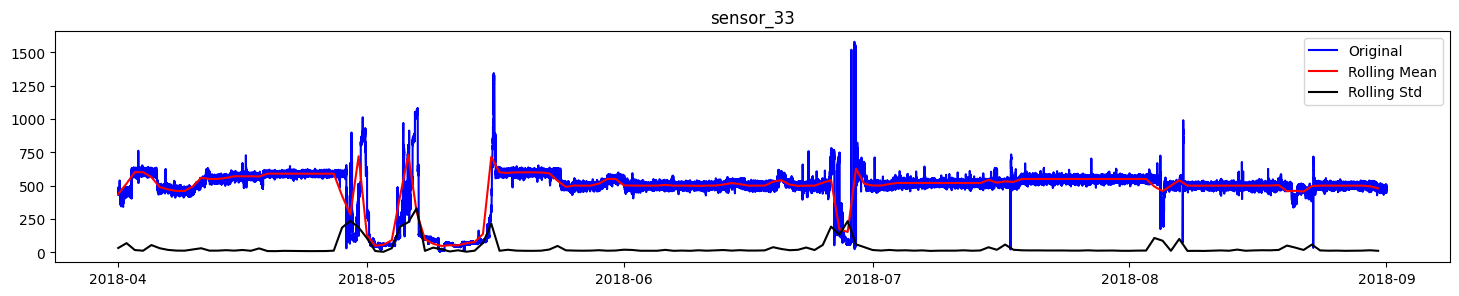

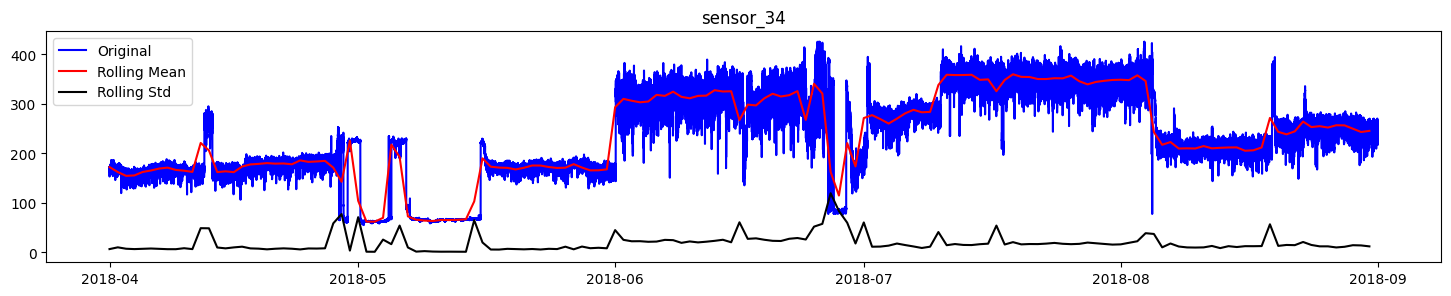

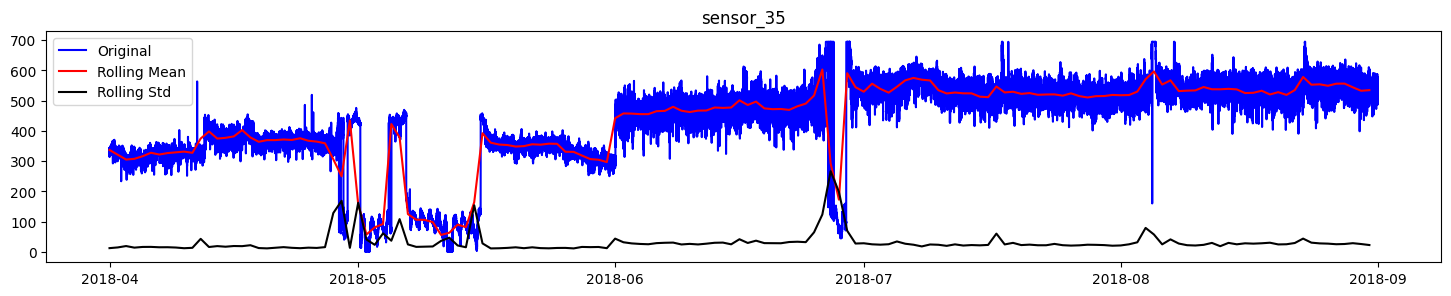

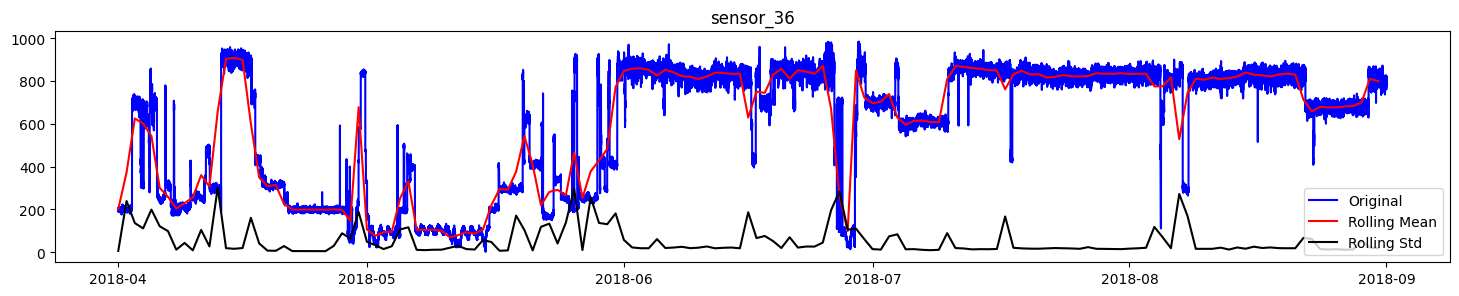

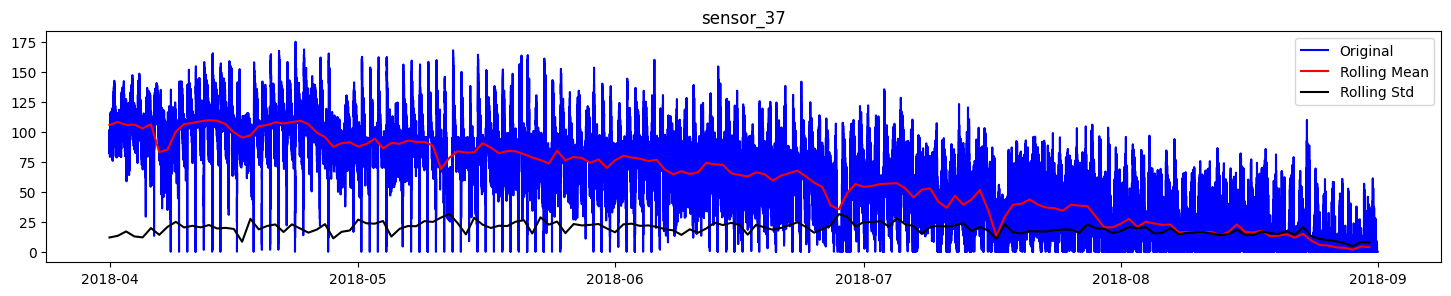

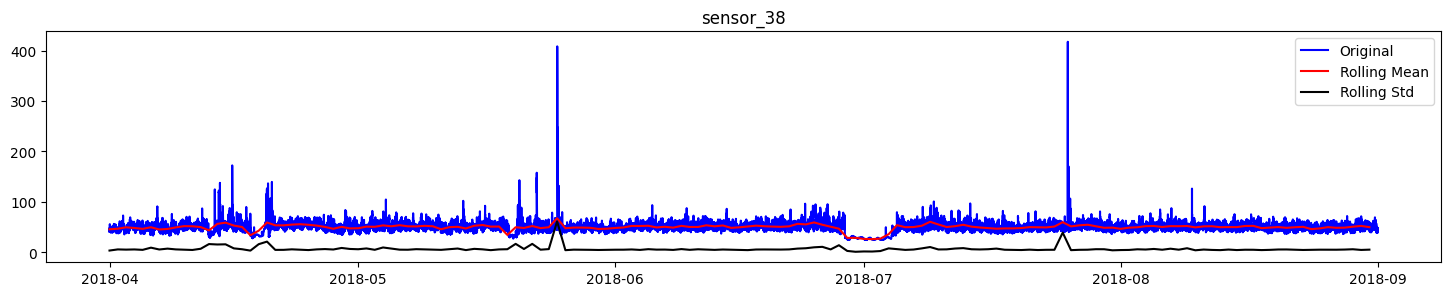

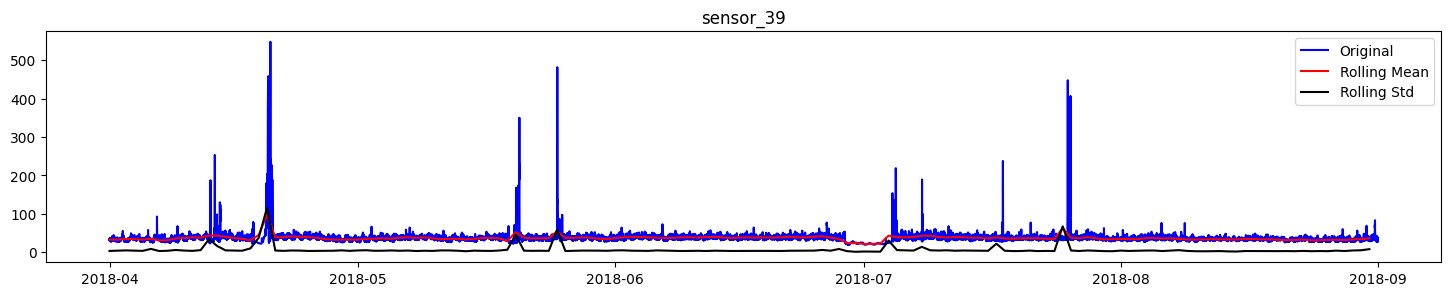

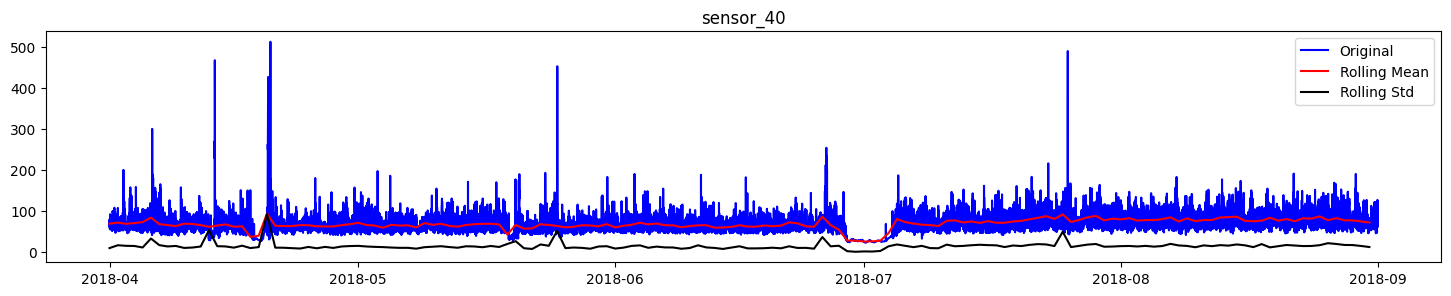

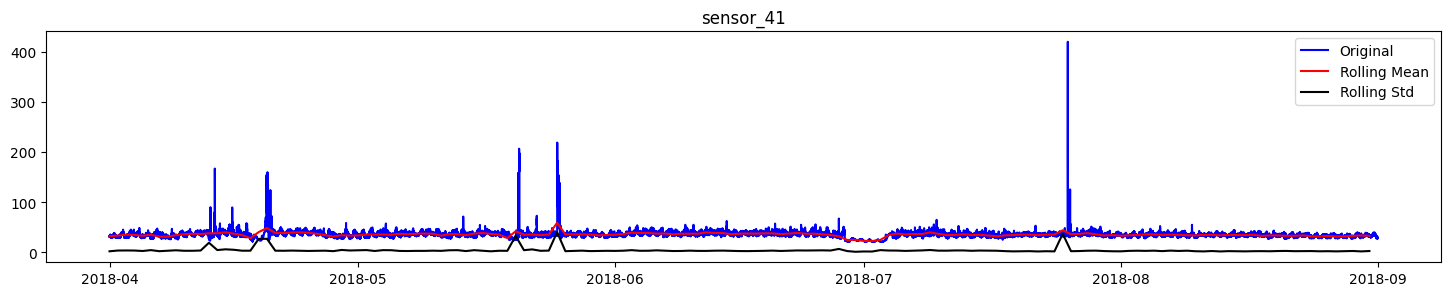

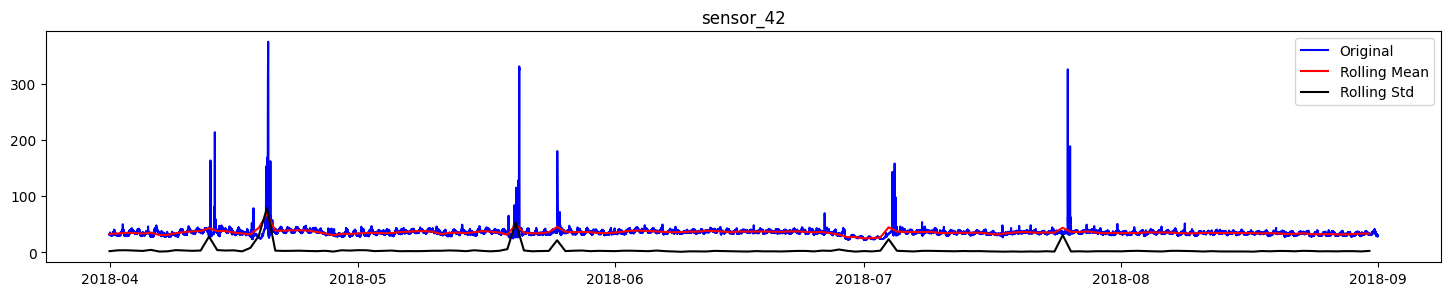

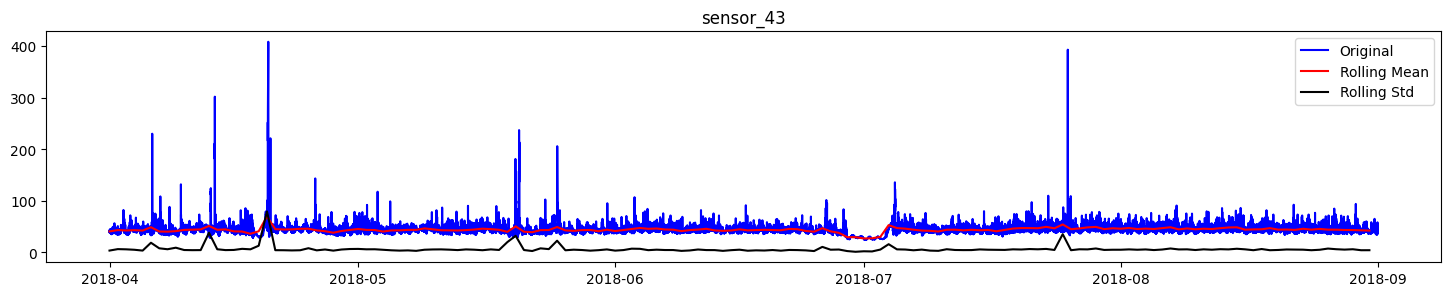

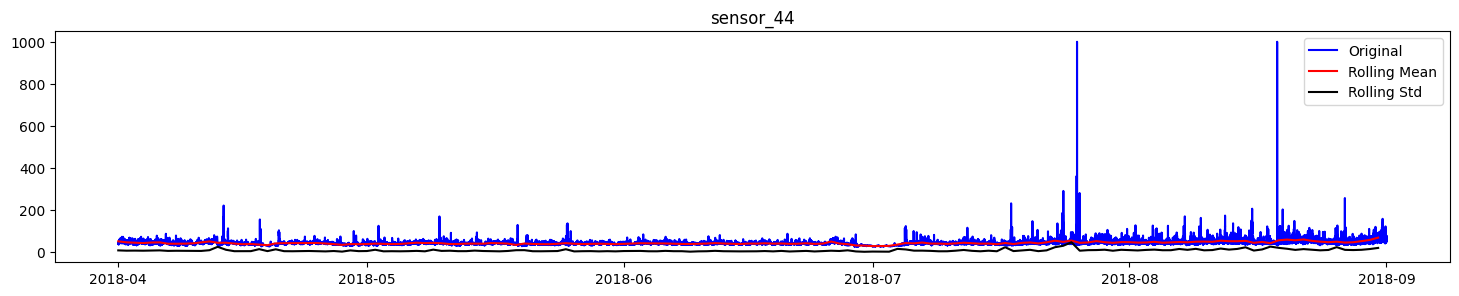

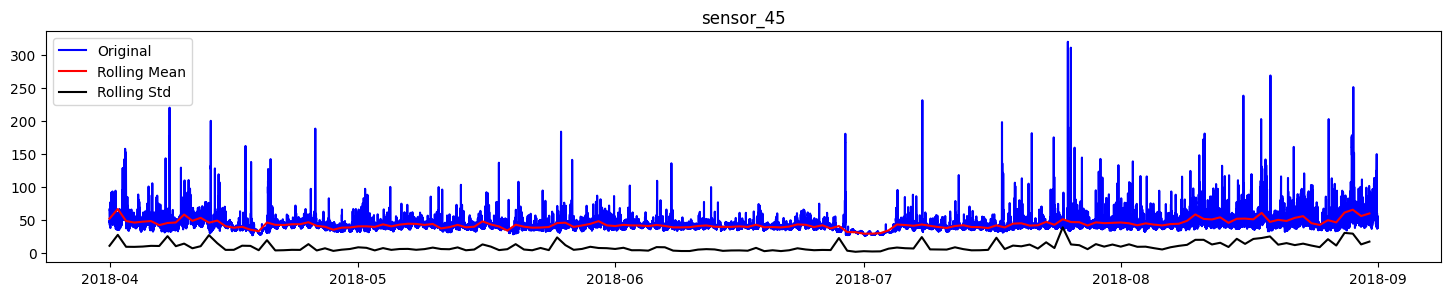

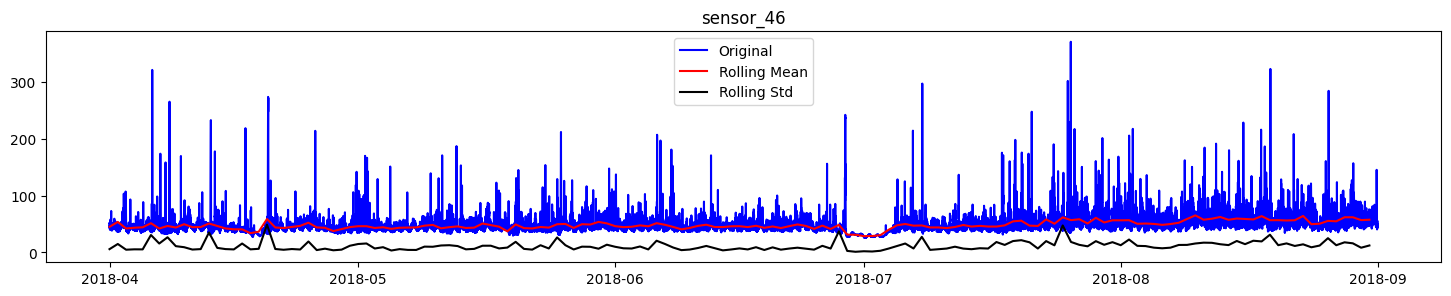

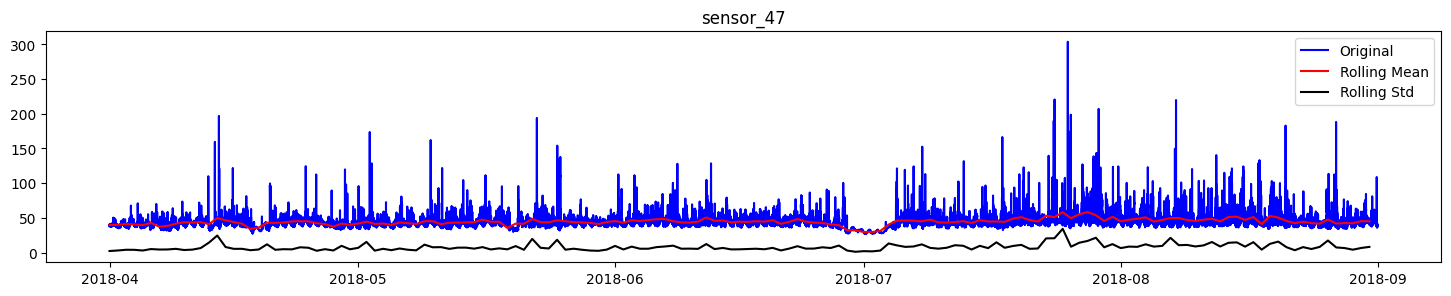

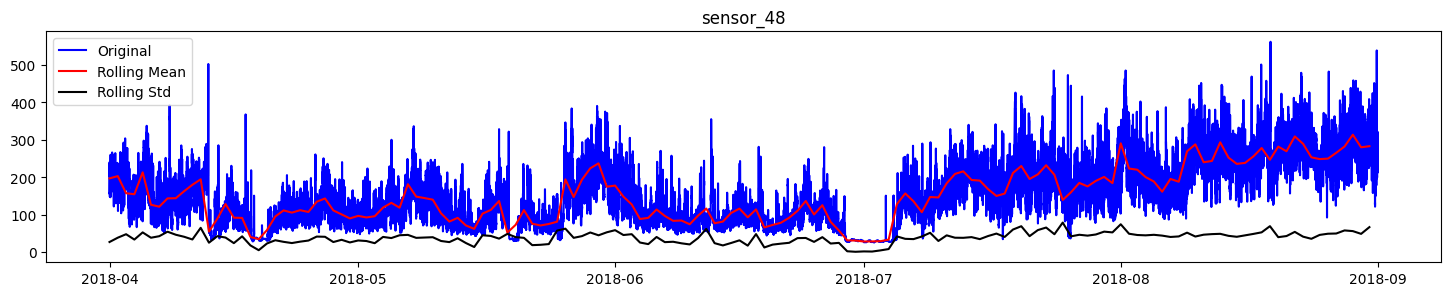

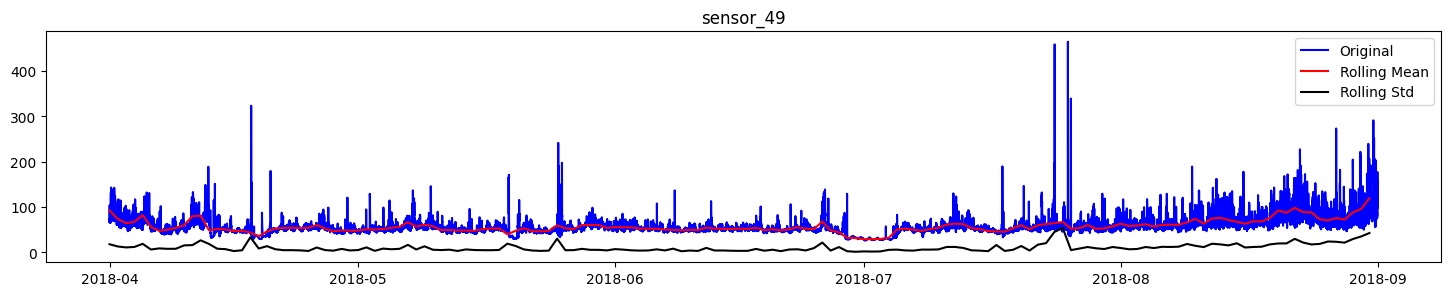

In [32]:
df_index_by_date = df_tidy.set_index('date')
df_index_by_date = df_index_by_date.drop(['machine_status'], axis=1)

# Resample the sensor columns by daily average
rollmean = df_index_by_date.loc[:, 'sensor_00':'sensor_51'].resample(rule='D').mean()
rollstd = df_index_by_date.loc[:, 'sensor_00':'sensor_51'].resample(rule='D').std()

# Plot time series for each sensor with its mean and standard deviation
for column in rollmean.columns:
    fig, ax = plt.subplots(figsize=(18, 3))
    ax.plot(df_index_by_date.index, df_index_by_date[column], color='blue', label='Original')
    ax.plot(rollmean.index, rollmean[column], color='red', label='Rolling Mean')
    ax.plot(rollstd.index, rollstd[column], color='black', label='Rolling Std')
    ax.legend(loc='best')
    ax.set_title(column)
    plt.show()

**Looking at the readings from one of the sensors, `sensor_17` in this case, notice that the data actually looks pretty stationary where the rolling mean and standard deviation don’t seem to change over time except during the downtime of the pump which is expected.** This was the case for most of the sensors in this data set but it may not always be the case in which situations various transformation methods must be applied to make the data stationary before training the data.

<a id='sect2_4'></a>
### <font color='darkgreen'>Dimensionality Reduction</font>
**It is pretty computationally expensive to train models with all of the 52 sensors/features and it is not efficient. Therefore, I will employ [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)** (<font color='brown'>PCA</font>) **technique to extract new features to be used for the modeling**. In order to properly apply PCA, the data must be scaled and standardized. This is because PCA and most of the learning algorithms are distance based algorithms. If noticed from the first 10 rows of the tidy data, the magnitude of the values from each feature is not consistent. Some are very small while some others are really large values. I will perform the following steps using the Pipeline library:
1. Scale the data
2. Perform PCA and look at the most important principal components based on inertia

In [27]:
# Extract the names of the numerical columns
X_df = df_tidy[df_tidy.columns.difference(['machine_status', 'date'])]
X_df.head()

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  sensor_05  \
0   2.465394   47.09201    53.2118  46.310760   634.3750   76.45975   
1   2.465394   47.09201    53.2118  46.310760   634.3750   76.45975   
2   2.444734   47.35243    53.2118  46.397570   638.8889   73.54598   
3   2.460474   47.09201    53.1684  46.397568   628.1250   76.98898   
4   2.445718   47.13541    53.2118  46.397568   636.4583   76.58897   

   sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_40  sensor_41  \
0   13.41146   16.13136   15.56713   15.05353  ...   70.57291   30.98958   
1   13.41146   16.13136   15.56713   15.05353  ...   70.57291   30.98958   
2   13.32465   16.03733   15.61777   15.01013  ...   69.53125   30.46875   
3   13.31742   16.24711   15.69734   15.08247  ...   72.13541   30.46875   
4   13.35359   16.21094   15.69734   15.08247  ...   76.82291   30.98958   

   sensor_42  sensor_43  sensor_44  sensor_45  sensor_46  sensor_47  \
0  31.770832   41.92708  39.641200   65.68287   50.92593  38.194440   
1  31.770832   41.92708  39.641200   65.68287   50.92593  38.194440   
2  31.770830   41.66666  39.351852   65.39352   51.21528  38.194443   
3  31.510420   40.88541  39.062500   64.81481   51.21528  38.194440   
4  31.510420   41.40625  38.773150   65.10416   51.79398  38.773150   

   sensor_48  sensor_49  
0   157.9861   67.70834  
1   157.9861   67.70834  
2   155.9606   67.12963  
3   155.9606   66.84028  
4   158.2755   66.55093  

[5 rows x 49 columns]

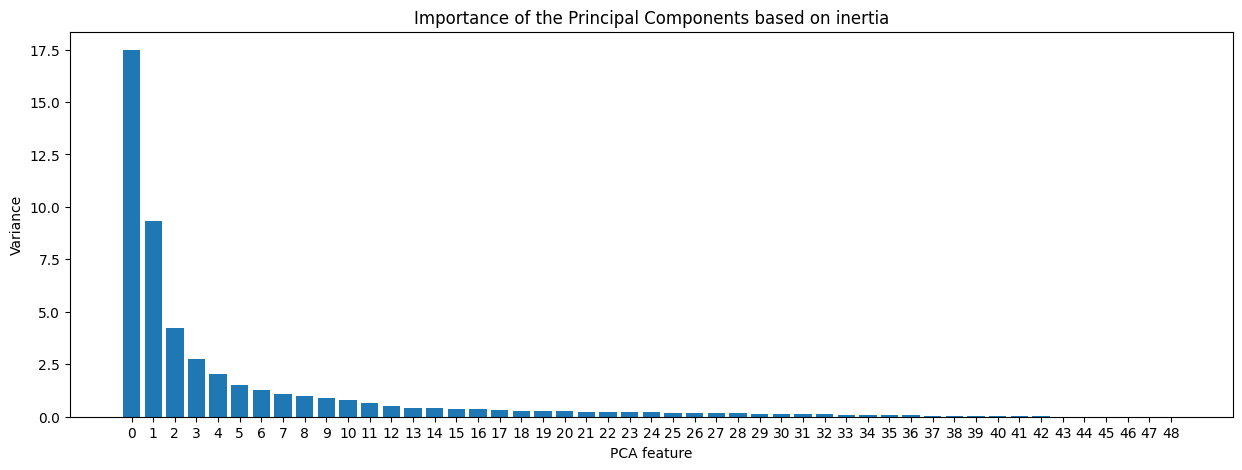

In [28]:
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X_df)

# Plot the principal components against their inertia
features = range(pca.n_components_)
_ = plt.figure(figsize=(15, 5))
_ = plt.bar(features, pca.explained_variance_)
_ = plt.xlabel('PCA feature')
_ = plt.ylabel('Variance')
_ = plt.xticks(features)
_ = plt.title("Importance of the Principal Components based on inertia")
plt.show()

It appears that the first two principal components are the most important as per the features extracted by the PCA in above importance plot. So as the next step, **I will perform PCA with 2 components which will be my features to be used in the training of the models.**

In [29]:
# Calculate PCA with 2 components
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_df)
principal_df = pd.DataFrame(data=principal_components, columns = ['pc1', 'pc2'])

Now, I will **check again the stationarity and autocorrelation of these two principal components just to be sure they are stationary and not autocorrelated by [Dickey Fuller Test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)**
> In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

* `p-value > 0.05`: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* `p-value <= 0.05`: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [30]:
# Run Augmented Dickey Fuller Test
result = adfuller(principal_df['pc1'])
# Print p-value
print(result[1])

2.4617182028210818e-05


Running the Dickey Fuller test on the 1st principal component, **I got a p-value of 2.461718202820985e-05 which is very small number** (<font color='brown'>much smaller than 0.05</font>). **Thus, I will reject the Null Hypothesis and say the data has a unit root and is non-stationary**. I performed the same on the 2nd component and got a similar result. So both of the principal components are stationary which is what I wanted.

Now, let’s check for autocorrelation in both of these principal components. It can be done one of the two ways; either with the pandas [autocorr()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.autocorr.html) method or ACF plot ([API:plot_acf](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)). I will use the latter in this case to quickly visually verify that there is no autocorrelation. The following code does just that.

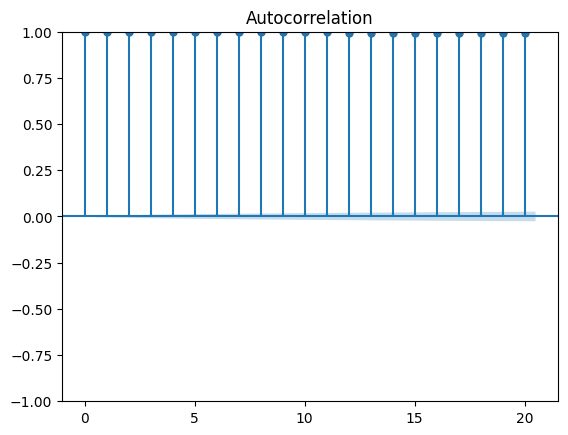

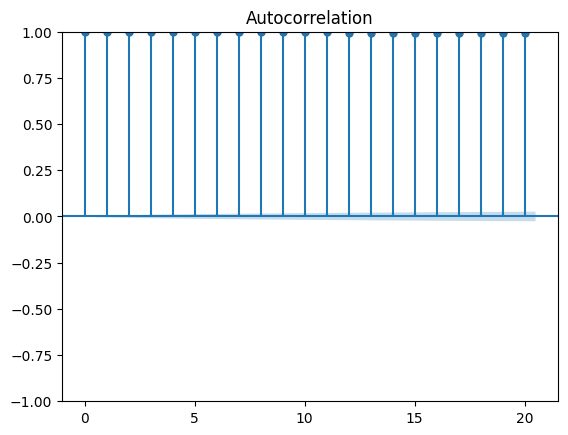

In [33]:
# Plot ACF
pca1_df = principal_df['pc1']
plot_acf(pca1_df.dropna(), lags=20, alpha=0.05)

**As seen above, the anomalies are detected right before the pump breaks down. This could be a very valuable information for an operator to see and be able to shut down the pump properly before it actually goes down hard.** Let’s see if we detect similar pattern in anomalies from the next two algorithms.

# Model  Building

In [37]:
import networkx as nx
import pandas as pd

# Load the data
data = pd.read_csv(r'C:\Users\SUJAN\preprocessed_data.csv') 

# Create an empty graph
graph = nx.Graph()

# Add nodes to the graph
sensors = data.columns[:-2]  # Exclude the 'machine_status' and 'date' columns
graph.add_nodes_from(sensors)

# Add edges to the graph
# Define the connections between sensors based on their proximity or any other criteria
# You can use a threshold or a distance measure to determine if two sensors are connected
# For example, you can connect sensors if their correlation coefficient is above a certain threshold
threshold = 0.8  # Adjust the threshold as per your requirements

for i, sensor1 in enumerate(sensors):
    for j, sensor2 in enumerate(sensors[i+1:]):
        correlation = data[sensor1].corr(data[sensor2])
        if correlation > threshold:
            graph.add_edge(sensor1, sensor2)

# Print some information about the constructed graph
print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())
print("Graph nodes:", graph.nodes())
print("Graph edges:", graph.edges())


Number of nodes: 49
Number of edges: 126
Graph nodes: ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30', 'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35', 'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49']
Graph edges: [('sensor_02', 'sensor_03'), ('sensor_02', 'sensor_04'), ('sensor_04', 'sensor_10'), ('sensor_04', 'sensor_11'), ('sensor_04', 'sensor_12'), ('sensor_06', 'sensor_07'), ('sensor_07', 'sensor_08'), ('sensor_07', 'sensor_09'), ('sensor_10', 'sensor_11'), ('sensor_11', 'sensor_12'), ('sensor_14', 

# import the required libraries:

In [7]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import GraphConv
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, precision_score, recall_score

In [8]:
class GraphConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GraphConv, self).__init__(aggr='add')
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        x = self.lin(x)
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j


In [9]:
class GNNModel(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes):
        super(GNNModel, self).__init__()

        self.conv1 = GraphConv(num_features, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = nn.ReLU()(x)
        x = self.conv2(x, edge_index)

        return x



In [10]:
edge_connections = [
    (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9),
    (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10),
    (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11),
    (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12),
    (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13),
    (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14),
    (6, 7), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15),
    (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16),
    (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (8, 16), (8, 17),
    (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (9, 16), (9, 17), (9, 18),
    (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (10, 16), (10, 17), (10, 18), (10, 19),
    (11, 12), (11, 13), (11, 14), (11, 15), (11, 16), (11, 17), (11, 18), (11, 19), (11, 20),
    (12, 13), (12, 14), (12, 15), (12, 16), (12, 17), (12, 18), (12, 19), (12, 20), (12, 21),
    (13, 14), (13, 15), (13, 16), (13, 17), (13, 18), (13, 19), (13, 20), (13, 21), (13, 22),
    (14, 15), (14, 16), (14, 17), (14, 18), (14, 19), (14, 20), (14, 21), (14, 22), (14, 23),
    (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (15, 21), (15, 22), (15, 23), (15, 24),
    (16, 17), (16, 18), (16, 19), (16, 20), (16, 21), (16, 22), (16, 23), (16, 24), (16, 25),
    (17, 18), (17, 19), (17, 20), (17, 21), (17, 22), (17, 23), (17, 24), (17, 25), (17, 26),
    (18, 19), (18, 20), (18, 21), (18, 22), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27),
    (19, 20), (19, 21), (19, 22), (19, 23), (19, 24), (19, 25), (19, 26), (19, 27), (19, 28),
    (20, 21), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 27), (20, 28), (20, 29),
    (21, 22), (21, 23), (21, 24), (21, 25), (21, 26), (21, 27), (21, 28), (21, 29), (21, 30),
    (22, 23), (22, 24), (22, 25), (22, 26), (22, 27), (22, 28), (22, 29), (22, 30), (22, 31),
    (23, 24), (23, 25), (23, 26), (23, 27), (23, 28), (23, 29), (23, 30), (23, 31), (23, 32),
    (24, 25), (24, 26), (24, 27), (24, 28), (24, 29), (24, 30), (24, 31), (24, 32), (24, 33),
    (25, 26), (25, 27), (25, 28), (25, 29), (25, 30), (25, 31), (25, 32), (25, 33), (25, 34),
    (26, 27), (26, 28), (26, 29), (26, 30), (26, 31), (26, 32), (26, 33), (26, 34), (26, 35),
    (27, 28), (27, 29), (27, 30), (27, 31), (27, 32), (27, 33), (27, 34), (27, 35), (27, 36),
    (28, 29), (28, 30), (28, 31), (28, 32), (28, 33), (28, 34), (28, 35), (28, 36), (28, 37),
    (29, 30), (29, 31), (29, 32), (29, 33), (29, 34), (29, 35), (29, 36), (29, 37), (29, 38),
    (30, 31), (30, 32), (30, 33), (30, 34), (30, 35), (30, 36), (30, 37), (30, 38), (30, 39),
    (31, 32), (31, 33), (31, 34), (31, 35), (31, 36), (31, 37), (31, 38), (31, 39), (31, 40),
    (32, 33), (32, 34), (32, 35), (32, 36), (32, 37), (32, 38), (32, 39), (32, 40), (32, 41),
    (33, 34), (33, 35), (33, 36), (33, 37), (33, 38), (33, 39), (33, 40), (33, 41), (33, 42),
    (34, 35), (34, 36), (34, 37), (34, 38), (34, 39), (34, 40), (34, 41), (34, 42), (34, 43),
    (35, 36), (35, 37), (35, 38), (35, 39), (35, 40), (35, 41), (35, 42), (35, 43), (35, 44),
    (36, 37), (36, 38), (36, 39), (36, 40), (36, 41), (36, 42), (36, 43), (36, 44), (36, 45),
    (37, 38), (37, 39), (37, 40), (37, 41), (37, 42), (37, 43), (37, 44), (37, 45), (37, 46),
    (38, 39), (38, 40), (38, 41), (38, 42), (38, 43), (38, 44), (38, 45), (38, 46), (38, 47),
    (39, 40), (39, 41), (39, 42), (39, 43), (39, 44), (39, 45), (39, 46), (39, 47), (39, 48),
    (40, 41), (40, 42), (40, 43), (40, 44), (40, 45), (40, 46), (40, 47), (40, 48), (41, 42), 
    (41, 43), (41, 44), (41, 45), (41, 46), (41, 47), (41, 48), (42, 43), (42, 44), (42, 45), 
    (42, 46), (42, 47), (42, 48), (43, 44), (43, 45), (43, 46), (43, 47), (43, 48),(44, 45), 
    (44, 46), (44, 47), (44, 48),(45, 46), (45, 47), (45, 48), (46, 47), (46, 48), (47, 48),
]
# Provide the list of edge connections



In [11]:

# Assuming `df` is your DataFrame containing the data
labels = df['machine_status'].map({'NORMAL': 0, 'BROKEN': 1, 'RECOVERING': 1})


NameError: name 'df' is not defined

In [ ]:
df_tidy.machine_status.value_counts()


In [12]:
#machine status -  pie chart
stroke_labels = ["Normal","Recovering","Broken"]
sizes = df_tidy.machine_status.value_counts()

plt.pie(x=sizes,labels=stroke_labels)
plt.show()

NameError: name 'df_tidy' is not defined

In [13]:
# Convert labels to a PyTorch tensor
labels = torch.tensor(labels.values)

NameError: name 'labels' is not defined

In [14]:
num_nodes = 49  # Number of nodes
num_features = 2  # Number of features per node (PC1 and PC2)

edge_index = torch.tensor(edge_connections, dtype=torch.long).t().contiguous()
x = torch.tensor(principal_df[['pc1', 'pc2']].values, dtype=torch.float)  # Use your actual PC1 and PC2 values here

data = Data(x=x, edge_index=edge_index)

NameError: name 'principal_df' is not defined

In [15]:
isolation_forest = IsolationForest(contamination=0.1)  # Adjust the contamination parameter as needed
anomaly_scores = isolation_forest.fit_predict(data.x.numpy())
anomaly_scores = torch.tensor(anomaly_scores)
print(anomaly_scores)

NameError: name 'data' is not defined

In [16]:
# Assuming you have the GNNModel class and data object defined
model = GNNModel(num_features=2, hidden_size=64, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [17]:
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    output = model(data)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_output = model(data)
        test_loss = criterion(test_output, labels)
        predicted_labels = torch.argmax(test_output, dim=1)

    # Compute evaluation metrics
    f1 = f1_score(labels, predicted_labels, average='weighted')
    precision = precision_score(labels, predicted_labels, average='weighted')
    recall = recall_score(labels, predicted_labels, average='weighted')

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}, Test Loss: {test_loss.item()}")
    print(f"F1 Score: {f1}, Precision: {precision}, Recall: {recall}")

NameError: name 'data' is not defined